# Open science support (OSSI) - descriptive analyses

This notebook produces all descriptive plots and tables related to the Open Science Support Index (OSSI) and its component indicators.

Input  
- `2.data/meta_under_request_tagged_open_science.tsv` (output of `08f_parse_open_science.py`)

Outputs (written to `4.analyses/open_science/`)  
- OSSI score distribution and temporal trends  
- OSSI score median and IQR by year  
- OSSI score boxplots and violin plots by year  
- Stacked 100% barplots of OSSI tiers by year and by journal  
- Percentage of papers with each open science indicator by year and by journal  

From `meta_under_request_tagged_open_science.tsv` there are 127 481 papers in total. The final OSSI tiering looks like this:

- Gold: 31 356 papers (24.6 %)
- Silver: 53 513 papers (42.0 %)
- Bronze: 31 200 papers (24.5 %)
- None: 11 412 papers (9.0 %)

These tiers are derived from the OSSI score as implemented in `08f_parse_open_science.py`:

- Gold: score ≥ 8
- Silver: score 5–7
- Bronze: score 2–4
- None: score 0–1 (almost all “None” papers have score 1)

### Code cell 1 - Matplotlib fonts and color defaults

In [90]:
# Matplotlib configuration: fonts, colors, export-friendly settings

import matplotlib as mpl
import matplotlib.pyplot as plt
from cycler import cycler

# Use TrueType fonts in PDF/EPS so text is selectable and not broken into glyphs
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42
mpl.rcParams["text.usetex"] = False

# Font: journal style sans-serif
mpl.rcParams["font.family"] = "sans-serif"
mpl.rcParams["font.sans-serif"] = ["Arial", "Helvetica", "DejaVu Sans", "Liberation Sans"]

# General figure aesthetics
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 300
mpl.rcParams["axes.spines.top"] = False
mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.grid"] = False
mpl.rcParams["axes.titlesize"] = 11
mpl.rcParams["axes.labelsize"] = 10
mpl.rcParams["xtick.labelsize"] = 9
mpl.rcParams["ytick.labelsize"] = 9
mpl.rcParams["legend.fontsize"] = 9

# Color palettes

# Okabe Ito colorblind safe palette
okabe_ito = [
    "#E69F00",  # orange
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#CC79A7",  # reddish purple
    "#000000",  # black
]

# Muted "scientific" palette
muted_scientific = [
    "#1b9e77",  # green
    "#d95f02",  # orange
    "#7570b3",  # purple
    "#e7298a",  # pink
    "#66a61e",  # olive green
    "#e6ab02",  # mustard
    "#a6761d",  # brown
    "#666666",  # gray
]

# Default cycle
mpl.rcParams["axes.prop_cycle"] = cycler(color=muted_scientific)


### Code cell 2 - Imports and project paths

In [91]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Years to display
YEAR_MIN, YEAR_MAX = 2010, 2025

# This notebook lives in 1.scripts/07_plots
notebook_dir = Path.cwd()
print("Notebook dir:", notebook_dir)

# Project root is one level above 1.scripts
project_root = notebook_dir.parents[1]
print("Project root:", project_root)

data_dir = project_root / "2.data"
out_root = project_root / "4.analyses"

# Output folder for open science plots
out_open = out_root / "open_science"
out_open.mkdir(parents=True, exist_ok=True)

print("Data dir:", data_dir)
print("Open science output dir:", out_open)


Notebook dir: /Users/benoit/work/under_request/1.scripts/07_plots
Project root: /Users/benoit/work/under_request
Data dir: /Users/benoit/work/under_request/2.data
Open science output dir: /Users/benoit/work/under_request/4.analyses/open_science


### Code cell 3 - Helper functions and data loading

In [92]:
def infer_year_column(df: pd.DataFrame) -> str:
    """
    Best effort guess of the publication year column.
    Prefers 'year' or 'pub_year', otherwise parses 'pubdate' like fields or extracts a 4 digit year by regex.
    """
    # direct year columns
    for c in df.columns:
        if c.lower() in ("year", "pub_year"):
            return c

    # parse date-like columns
    for c in df.columns:
        if c.lower() in ("pubdate", "date", "publication_date"):
            ser = pd.to_datetime(df[c], errors="coerce", infer_datetime_format=True)
            if ser.notna().any():
                df["_year"] = ser.dt.year
                return "_year"

    # fallback: regex search on any column
    for c in df.columns:
        ser = df[c].astype(str).str.extract(r"(\d{4})", expand=False)
        yy = pd.to_numeric(ser, errors="coerce")
        if yy.notna().any():
            df["_year"] = yy
            return "_year"

    raise SystemExit("Could not infer a year column. Please add a 'year' or 'pub_year' column.")

def infer_journal_column(df: pd.DataFrame) -> str:
    """Best effort guess of the journal column."""
    candidates = [
        "journal", "journal_name", "journal_title", "journal_full", "source",
        "journal_abbrev", "journal_abbreviation", "journal-title",
    ]
    low = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand in low:
            return low[cand]
    for c in df.columns:
        if "journal" in c.lower():
            return c
    raise SystemExit("Could not infer a journal column. Add 'journal' or similar.")

def to_bool_series(s: pd.Series) -> pd.Series:
    """
    Convert heterogeneous values to boolean.
    - numeric: True if > 0
    - strings: True if in {'1','true','yes','y'} (case insensitive)
               False if empty/NA/'0'/'false'/'no'/'n'
               otherwise non empty values are treated as True.
    """
    if s.dtype.kind in "biufc":
        return pd.to_numeric(s, errors="coerce").fillna(0) > 0

    low = s.astype(str).str.strip().str.lower()
    true_set = {"1", "true", "yes", "y"}
    false_set = {"", "0", "false", "no", "n", "na", "nan", "none"}

    out = pd.Series(False, index=s.index)
    out = out.where(~low.isin(true_set), True)
    out = out.where(~low.isin(false_set), False)
    # anything else non empty is considered True
    mask_other = ~low.isin(true_set | false_set) & (low != "")
    out = out.where(~mask_other, True)
    return out

# Load the OSSI enriched corpus
in_tsv = data_dir / "meta_under_request_tagged_open_science.tsv"
df_all = pd.read_csv(in_tsv, sep="\t", dtype=str).fillna("")
print(f"Loaded {len(df_all):,} rows from {in_tsv}")

# Infer year and restrict to the analysis window
year_col = infer_year_column(df_all)
df_all[year_col] = pd.to_numeric(df_all[year_col], errors="coerce")
df = df_all[(df_all[year_col] >= YEAR_MIN) & (df_all[year_col] <= YEAR_MAX)].copy()

# OSSI score and tier
df["ossi_score"] = pd.to_numeric(df["ossi_score"], errors="coerce")
year_values = sorted(df[year_col].dropna().unique())
print("Years present in analysis window:", year_values[:5], "...", year_values[-5:])
print("Number of rows after year filter:", len(df))

journal_col = infer_journal_column(df)
print("Journal column:", journal_col)


Loaded 127,481 rows from /Users/benoit/work/under_request/2.data/meta_under_request_tagged_open_science.tsv
Years present in analysis window: [np.int64(2010), np.int64(2011), np.int64(2012), np.int64(2013), np.int64(2014)] ... [np.int64(2021), np.int64(2022), np.int64(2023), np.int64(2024), np.int64(2025)]
Number of rows after year filter: 127481
Journal column: journal


### Global OSSI sanity checks

- Normalise ossi_tier before the sanity check
- Converts empty strings to "None" in ossi_tier.
- Then recomputes the tier from the score and compares.

In [93]:
# Global OSSI sanity checks
import numpy as np
import pandas as pd

print("### Global OSSI sanity checks ###")

# 0) Normalise ossi_tier: empty strings / NaNs -> "None"
df["ossi_tier"] = (
    df["ossi_tier"]
    .replace("", np.nan)        # treat empty strings as missing
    .fillna("None")             # and encode them explicitly as "None"
)

OSSI_TIERS = ["Gold", "Silver", "Bronze", "None"]

def tier_from_score(score: float) -> str:
    """Map OSSI score to tier using the final thresholds."""
    if pd.isna(score):
        return np.nan
    if score >= 8:
        return "Gold"
    elif score >= 5:
        return "Silver"
    elif score >= 2:
        return "Bronze"
    else:
        return "None"

# 1) Make sure ossi_score is numeric
df["ossi_score"] = pd.to_numeric(df["ossi_score"], errors="coerce")

# 2) Compare stored tier vs recomputed tier
df["ossi_tier_recomputed"] = df["ossi_score"].apply(tier_from_score)
stored = df["ossi_tier"]
recomp = df["ossi_tier_recomputed"]

n_mismatch = (stored != recomp).sum()
print(f"Mismatches between stored ossi_tier and score-based tier: {n_mismatch}")

# 3) Check for missing scores / tiers
n_missing_score = df["ossi_score"].isna().sum()
n_missing_tier  = df["ossi_tier"].isna().sum()
print(f"Papers with missing ossi_score: {n_missing_score}")
print(f"Papers with missing ossi_tier:  {n_missing_tier}")

# 4) Tier counts after normalisation
tier_counts = df["ossi_tier"].value_counts(dropna=False)
tier_counts = tier_counts.reindex(OSSI_TIERS, fill_value=0)

print("\nTier counts in full meta table (normalised):")
print(tier_counts)

# Optional: drop helper column
df = df.drop(columns=["ossi_tier_recomputed"])


### Global OSSI sanity checks ###
Mismatches between stored ossi_tier and score-based tier: 0
Papers with missing ossi_score: 0
Papers with missing ossi_tier:  0

Tier counts in full meta table (normalised):
ossi_tier
Gold      31356
Silver    53513
Bronze    31200
None      11412
Name: count, dtype: int64


## 12. Global OSSI tier distribution across all papers

Here we summarise the overall distribution of OSSI tiers across the full analysis corpus (restricted to `ok_analysis == 1`). For each tier (Gold, Silver, Bronze, None) we report the number of papers and percentage of the total, and visualise the distribution as:

- a single stacked 100 percent bar,
- a pie chart,
- a donut chart.

The backing TSV gives the exact counts and percentages used for all three plots.


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_global_donut_pie_bar/ossi_global_tier_counts.tsv

Global OSSI tier distribution (ok_analysis == 1):


,tier,n,pct
0,Gold,31010,25.168207
1,Silver,51602,41.881001
2,Bronze,30260,24.559495
3,None,10339,8.391296


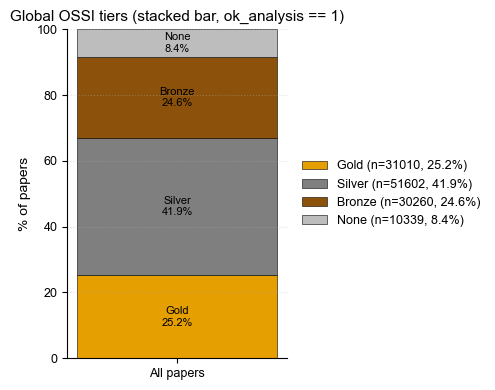

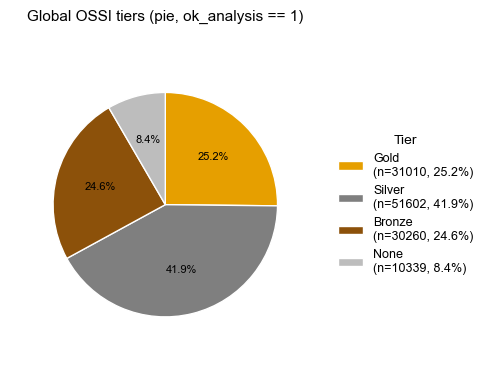

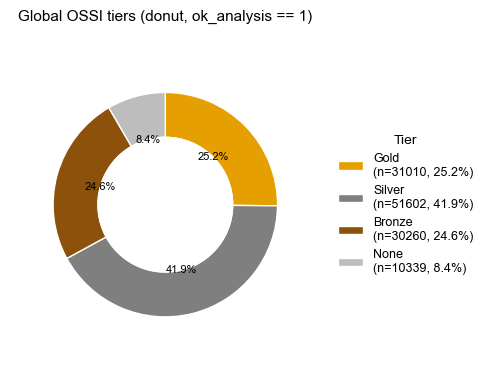

In [94]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# Ensure OSSI_TIERS and palette_tiers exist (reuse from earlier cells)
OSSI_TIERS = ["Gold", "Silver", "Bronze", "None"]
palette_tiers = {
    "Gold":   "#E69F00",
    "Silver": "#7F7F7F",
    "Bronze": "#8C510A",
    "None":   "#BDBDBD",
}

# Output folder for these global plots
out_global = out_open / "ossi_global_donut_pie_bar"
out_global.mkdir(parents=True, exist_ok=True)

# Filter to ok_analysis == 1 if the column exists
df_ok = df.copy()
if "ok_analysis" in df_ok.columns:
    df_ok["ok_analysis_num"] = pd.to_numeric(df_ok["ok_analysis"], errors="coerce").fillna(0).astype(int)
    df_ok = df_ok[df_ok["ok_analysis_num"] == 1].copy()

# Normalise ossi_tier: empty strings / NaNs -> "None"
df_ok["ossi_tier"] = (
    df_ok["ossi_tier"]
    .replace("", np.nan)
    .fillna("None")
)

# Counts and percentages for all four tiers
counts = df_ok["ossi_tier"].value_counts().reindex(OSSI_TIERS, fill_value=0)
total = int(counts.sum())
pct = counts / total * 100.0

summary_global = pd.DataFrame(
    {
        "tier": OSSI_TIERS,
        "n": [int(counts[t]) for t in OSSI_TIERS],
        "pct": [pct[t] for t in OSSI_TIERS],
    }
)

# Save TSV
tsv_global = out_global / "ossi_global_tier_counts.tsv"
summary_global.to_csv(tsv_global, sep="\t", index=False)
print(f"Wrote {tsv_global}")
print("\nGlobal OSSI tier distribution (ok_analysis == 1):")
display(summary_global)

# ---------- 1) Stacked barplot ----------

fig_bar, ax = plt.subplots(figsize=(5, 4))

x = [0]  # single bar
bottom = 0.0

for tier in OSSI_TIERS:
    h = pct[tier]
    ax.bar(
        x,
        h,
        bottom=bottom,
        color=palette_tiers[tier],
        edgecolor="black",
        linewidth=0.4,
        label=f"{tier} (n={counts[tier]}, {h:.1f}%)",
    )
    # Annotate inside the segment if reasonably large
    if h > 5:
        ax.text(
            x[0],
            bottom + h / 2,
            f"{tier}\n{h:.1f}%",
            ha="center",
            va="center",
            fontsize=8,
            color="black",
        )
    bottom += h

ax.set_xticks(x)
ax.set_xticklabels(["All papers"])
ax.set_ylim(0, 100)
ax.set_ylabel("% of papers")
ax.set_title("Global OSSI tiers (stacked bar, ok_analysis == 1)")
ax.grid(True, axis="y", linestyle=":", alpha=0.4)

# Legend outside on the right
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

fig_bar.tight_layout()

fig_bar_png = out_global / "ossi_global_bar.png"
fig_bar_pdf = out_global / "ossi_global_bar.pdf"
fig_bar.savefig(fig_bar_png)
fig_bar.savefig(fig_bar_pdf)

# ---------- 2) Pie chart ----------

fig_pie, axp = plt.subplots(figsize=(5, 4))

labels = [f"{tier}\n(n={counts[tier]}, {pct[tier]:.1f}%)" for tier in OSSI_TIERS]
sizes = [pct[t] for t in OSSI_TIERS]
colors = [palette_tiers[t] for t in OSSI_TIERS]

def autopct_fmt(val):
    return f"{val:.1f}%"

wedges, texts, autotexts = axp.pie(
    sizes,
    labels=None,
    autopct=autopct_fmt,
    startangle=90,
    counterclock=False,
    colors=colors,
    wedgeprops=dict(edgecolor="white"),
    textprops=dict(fontsize=8),
)

axp.set_title("Global OSSI tiers (pie, ok_analysis == 1)")
axp.axis("equal")

# Legend with n and %
axp.legend(
    wedges,
    labels,
    title="Tier",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
)

fig_pie.tight_layout()

fig_pie_png = out_global / "ossi_global_pie.png"
fig_pie_pdf = out_global / "ossi_global_pie.pdf"
fig_pie.savefig(fig_pie_png)
fig_pie.savefig(fig_pie_pdf)

# ---------- 3) Donut chart ----------

fig_donut, axd = plt.subplots(figsize=(5, 4))

wedges_d, _, autotexts_d = axd.pie(
    sizes,
    labels=None,
    autopct=autopct_fmt,
    startangle=90,
    counterclock=False,
    colors=colors,
    wedgeprops=dict(width=0.4, edgecolor="white"),
    textprops=dict(fontsize=8),
)

# Draw white circle in the middle for donut
centre_circle = plt.Circle((0, 0), 0.6, color="white", fc="white")
axd.add_artist(centre_circle)

axd.set_title("Global OSSI tiers (donut, ok_analysis == 1)")
axd.axis("equal")

axd.legend(
    wedges_d,
    labels,
    title="Tier",
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
    frameon=False,
)

fig_donut.tight_layout()

fig_donut_png = out_global / "ossi_global_donut.png"
fig_donut_pdf = out_global / "ossi_global_donut.pdf"
fig_donut.savefig(fig_donut_png)
fig_donut.savefig(fig_donut_pdf)

# Show all three plots in the notebook
display(fig_bar)
display(fig_pie)
display(fig_donut)
plt.close(fig_bar)
plt.close(fig_pie)
plt.close(fig_donut)


## 12. Global OSSI tier distribution across all papers and UR strata

We finally compare the OSSI tier distribution across three related subsets:

1. all articles with `ok_analysis == 1` (full analysis corpus),
2. the subset with `ok_analysis == 1` and **no** “under request” wording (`under_request == 0`, labelled *ok=1 & not_UR*),
3. the subset with `ok_analysis == 1` and at least one “under request” statement (`under_request == 1`, labelled *ok=1 & UR=1*).

For each subset we compute, for every OSSI tier (Gold, Silver, Bronze, None), the number of papers and the within-subset percentage. The stacked barplot below shows one 100 % bar per subset, with both counts and percentages annotated inside each tier segment. This makes it possible to directly assess whether papers with “under request” wording tend to occupy lower OSSI tiers than papers without such statements.


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_global_donut_pie_bar/ossi_tier_counts_by_UR_status.tsv


tier,Gold,Silver,Bronze,None
group,,,,
ok=1 (all),25.2,41.9,24.6,8.4
ok=1 & not_UR,27.0,42.4,21.3,9.2
ok=1 & UR=1,15.6,39.4,41.0,4.0


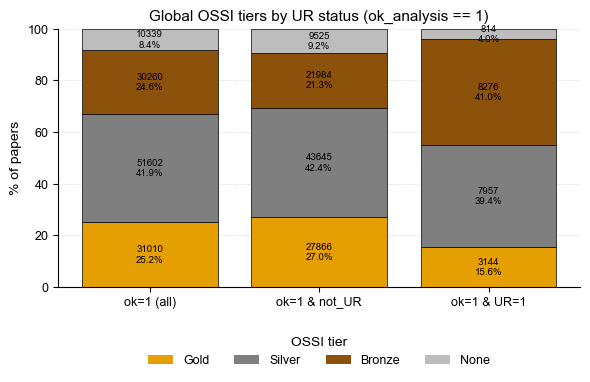

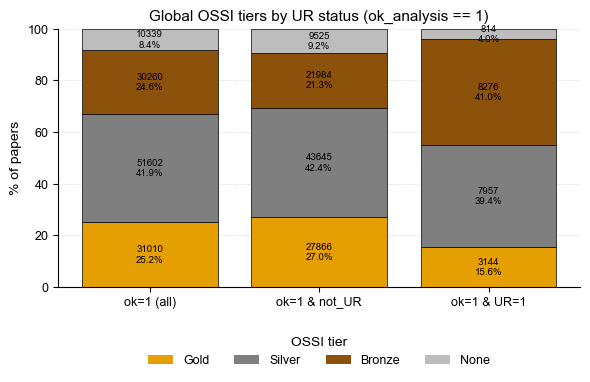

In [95]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display

# Ensure numeric flags and normalised ossi_tier
df_ur = df.copy()

df_ur["ok_analysis_num"] = (
    pd.to_numeric(df_ur.get("ok_analysis", 0), errors="coerce")
    .fillna(0)
    .astype(int)
)

df_ur["under_request_num"] = (
    pd.to_numeric(df_ur.get("under_request", 0), errors="coerce")
    .fillna(0)
    .astype(int)
)

df_ur["ossi_tier"] = (
    df_ur["ossi_tier"]
    .replace("", np.nan)
    .fillna("None")
)

OSSI_TIERS = ["Gold", "Silver", "Bronze", "None"]

# Define the three subsets
sub_all    = df_ur[df_ur["ok_analysis_num"] == 1].copy()
sub_notUR  = sub_all[sub_all["under_request_num"] == 0].copy()
sub_UR     = sub_all[sub_all["under_request_num"] == 1].copy()

groups = [
    ("ok=1 (all)",   sub_all),
    ("ok=1 & not_UR", sub_notUR),
    ("ok=1 & UR=1",  sub_UR),
]

# Compute counts and percentages per tier within each subset
rows = []
for label, sub in groups:
    total = len(sub)
    counts = sub["ossi_tier"].value_counts().reindex(OSSI_TIERS, fill_value=0)
    for tier in OSSI_TIERS:
        n = int(counts[tier])
        pct = 100.0 * n / total if total > 0 else 0.0
        rows.append(
            {
                "group": label,
                "tier": tier,
                "n": n,
                "pct": pct,
                "total": total,
            }
        )

summary_ur = pd.DataFrame(rows)

# Save TSV
out_global = out_open / "ossi_global_donut_pie_bar"
out_global.mkdir(parents=True, exist_ok=True)

tsv_path = out_global / "ossi_tier_counts_by_UR_status.tsv"
summary_ur.to_csv(tsv_path, sep="\t", index=False)
print(f"Wrote {tsv_path}")

# Show a wide table of percentages for a quick check
display(
    summary_ur.pivot(index="group", columns="tier", values="pct")
    .reindex(index=[g[0] for g in groups], columns=OSSI_TIERS)
    .round(1)
)

# Prepare tables for plotting
pct_tbl = (
    summary_ur.pivot(index="group", columns="tier", values="pct")
    .reindex(index=[g[0] for g in groups], columns=OSSI_TIERS)
    .fillna(0.0)
)

n_tbl = (
    summary_ur.pivot(index="group", columns="tier", values="n")
    .reindex(index=[g[0] for g in groups], columns=OSSI_TIERS)
    .fillna(0)
)

# --- Stacked barplot in % ---

fig, ax = plt.subplots(figsize=(6.0, 4.0))

x = np.arange(len(pct_tbl.index))
bottom = np.zeros(len(x))

for tier in OSSI_TIERS:
    vals = pct_tbl[tier].values
    ax.bar(
        x,
        vals,
        bottom=bottom,
        color=palette_tiers[tier],
        edgecolor="black",
        linewidth=0.5,
        label=tier,
    )

    # annotate inside each segment (if reasonably large)
    for i, v in enumerate(vals):
        if v > 4.0:  # threshold in %
            n_val = int(n_tbl.loc[pct_tbl.index[i], tier])
            ax.text(
                x[i],
                bottom[i] + v / 2.0,
                f"{n_val}\n{v:.1f}%",
                ha="center",
                va="center",
                fontsize=7,
            )

    bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(pct_tbl.index, rotation=0)
ax.set_ylim(0, 100)
ax.set_ylabel("% of papers")
ax.set_title("Global OSSI tiers by UR status (ok_analysis == 1)")

ax.yaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
ax.set_axisbelow(True)

# Legend for tiers
handles = [
    mpl.patches.Patch(facecolor=palette_tiers[t], label=t) for t in OSSI_TIERS
]
ax.legend(
    handles,
    [h.get_label() for h in handles],
    title="OSSI tier",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=len(OSSI_TIERS),
    frameon=False,
)

fig.tight_layout()

png_path = out_global / "ossi_global_bar_by_UR_status.png"
pdf_path = out_global / "ossi_global_bar_by_UR_status.pdf"
fig.savefig(png_path)
fig.savefig(pdf_path)

fig


### Loading the TSV files and params
*   Some basic plotting defaults
*   Years to display
*   Data dirs and files
*   Output folders

## 1. Global distribution of OSSI scores

First, we summarise the overall distribution of OSSI scores across all papers between 2010 and 2025.


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_score_summary_global.tsv


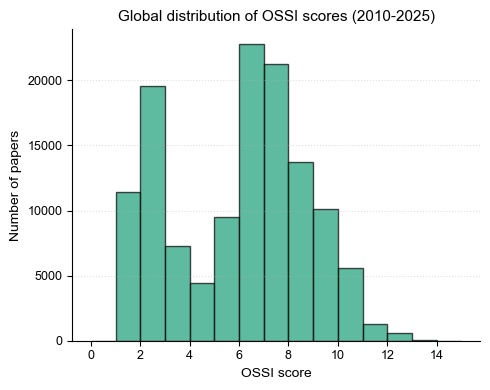

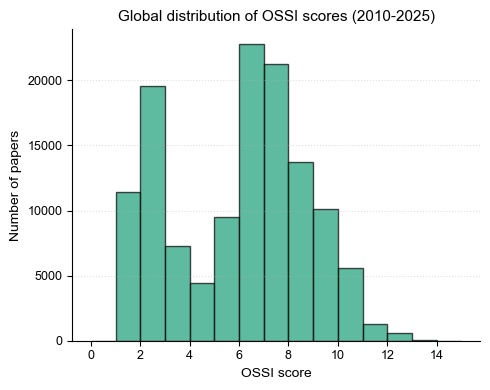

In [67]:
import numpy as np

# Drop missing scores
scores = df["ossi_score"].dropna()

# Summary statistics
summary_global = pd.DataFrame(
    {
        "n": [scores.size],
        "min": [scores.min()],
        "q25": [scores.quantile(0.25)],
        "median": [scores.median()],
        "mean": [scores.mean()],
        "q75": [scores.quantile(0.75)],
        "max": [scores.max()],
    }
)

summary_tsv = out_open / "ossi_score_summary_global.tsv"
summary_global.to_csv(summary_tsv, sep="\t", index=False)
print(f"Wrote {summary_tsv}")

# Histogram
fig, ax = plt.subplots(figsize=(5, 4))
ax.hist(scores, bins=range(int(scores.min()), int(scores.max()) + 2), edgecolor="black", alpha=0.7)
ax.set_xlabel("OSSI score")
ax.set_ylabel("Number of papers")
ax.set_title("Global distribution of OSSI scores (2010-2025)")
ax.grid(True, axis="y", linestyle=":", alpha=0.4)

png = out_open / "ossi_score_hist_all.png"
pdf = out_open / "ossi_score_hist_all.pdf"
fig.tight_layout()
fig.savefig(png)
fig.savefig(pdf)

fig


## 2. OSSI scores by year - median and IQR

We now summarise the OSSI score distribution by publication year, using the median and interquartile range as robust statistics. The backing TSV contains the sample size and summary per year.


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_score_median_iqr_by_year.tsv


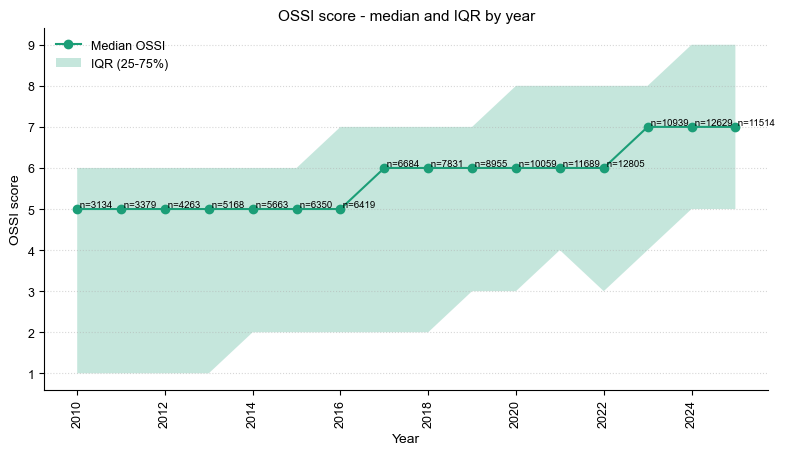

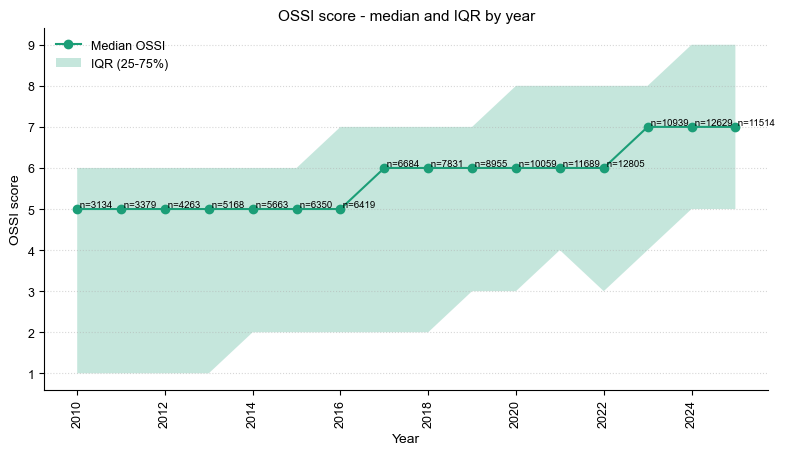

In [68]:
def summarize_score_by_year(df: pd.DataFrame, year_col: str) -> pd.DataFrame:
    d = df[[year_col, "ossi_score"]].dropna().copy()
    d[year_col] = pd.to_numeric(d[year_col], errors="coerce")
    d = d.dropna(subset=[year_col])
    grp = d.groupby(year_col)["ossi_score"]
    summary = grp.agg(
        n="size",
        q25=lambda s: s.quantile(0.25),
        median="median",
        q75=lambda s: s.quantile(0.75),
    ).reset_index().rename(columns={year_col: "year"})
    summary = summary.sort_values("year")
    return summary

summary_year = summarize_score_by_year(df, year_col)

out_tsv = out_open / "ossi_score_median_iqr_by_year.tsv"
summary_year.to_csv(out_tsv, sep="\t", index=False)
print(f"Wrote {out_tsv}")

# Plot
fig_w = max(8, 0.4 * len(summary_year))
fig, ax = plt.subplots(figsize=(fig_w, 4.5))

ax.plot(summary_year["year"], summary_year["median"], marker="o", label="Median OSSI")
ax.fill_between(
    summary_year["year"],
    summary_year["q25"],
    summary_year["q75"],
    alpha=0.25,
    label="IQR (25-75%)",
)

for _, row in summary_year.iterrows():
    ax.text(
        row["year"],
        row["median"],
        f" n={int(row['n'])}",
        fontsize=7,
        ha="left",
        va="bottom",
    )

ax.set_xlabel("Year")
ax.set_ylabel("OSSI score")
ax.set_title("OSSI score - median and IQR by year")
ax.grid(True, axis="y", linestyle=":", alpha=0.5)
ax.legend(loc="best", frameon=False)

png = out_open / "ossi_score_median_iqr_by_year.png"
pdf = out_open / "ossi_score_median_iqr_by_year.pdf"
fig.tight_layout()
ax.tick_params(axis="x", rotation=90)
fig.savefig(png)
fig.savefig(pdf)

fig


## 3. OSSI score distribution by year - boxplots

Boxplots highlight the dispersion and skew of OSSI scores for each year without relying on summary lines only. The backing TSV contains one row per paper (long format).


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_score_boxplot_by_year.tsv


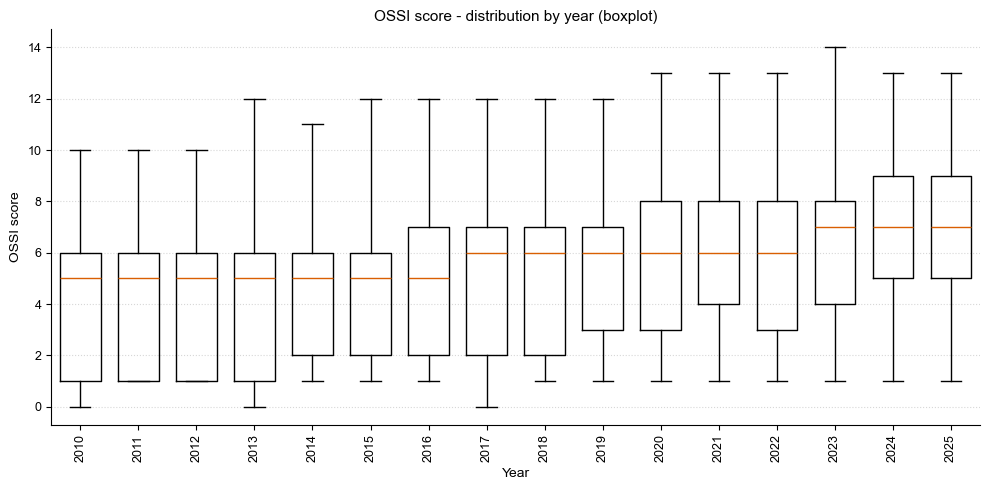

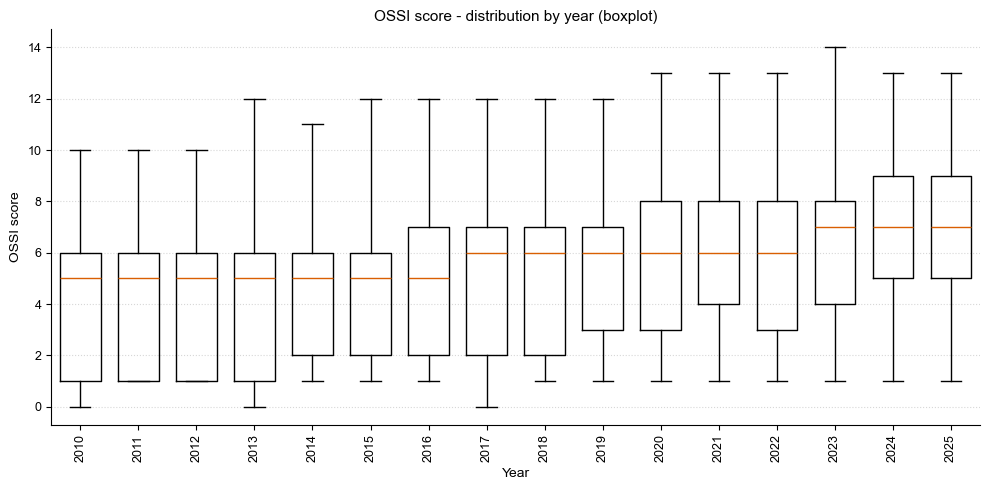

In [69]:
# Long format TSV for provenance
box_tsv = out_open / "ossi_score_boxplot_by_year.tsv"
df[[year_col, "ossi_score"]].rename(columns={year_col: "year"}).to_csv(box_tsv, sep="\t", index=False)
print(f"Wrote {box_tsv}")

# Prepare data
d = df[[year_col, "ossi_score"]].dropna().copy()
d[year_col] = pd.to_numeric(d[year_col], errors="coerce")
d = d.dropna(subset=[year_col])
years_present = sorted(d[year_col].unique())
data_by_year = [d.loc[d[year_col] == y, "ossi_score"].values for y in years_present]

fig_w = max(10, 0.4 * len(years_present))
fig, ax = plt.subplots(figsize=(fig_w, 5))

positions = np.arange(1, len(years_present) + 1)
bp = ax.boxplot(
    data_by_year,
    positions=positions,
    widths=0.7,
    showfliers=False,
)

ax.set_xticks(positions)
ax.set_xticklabels([str(int(y)) for y in years_present], rotation=90, ha="center")
ax.set_xlim(0.5, len(years_present) + 0.5)

ax.set_xlabel("Year")
ax.set_ylabel("OSSI score")
ax.set_title("OSSI score - distribution by year (boxplot)")
ax.grid(True, axis="y", linestyle=":", alpha=0.5)

png = out_open / "ossi_score_boxplot_by_year.png"
pdf = out_open / "ossi_score_boxplot_by_year.pdf"
fig.tight_layout()
fig.savefig(png)
fig.savefig(pdf)

fig


## 4. OSSI score distribution by year - violin plots

Violin plots provide a smoothed view of the full score distribution per year, complementing boxplots.


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_score_violin_by_year.tsv


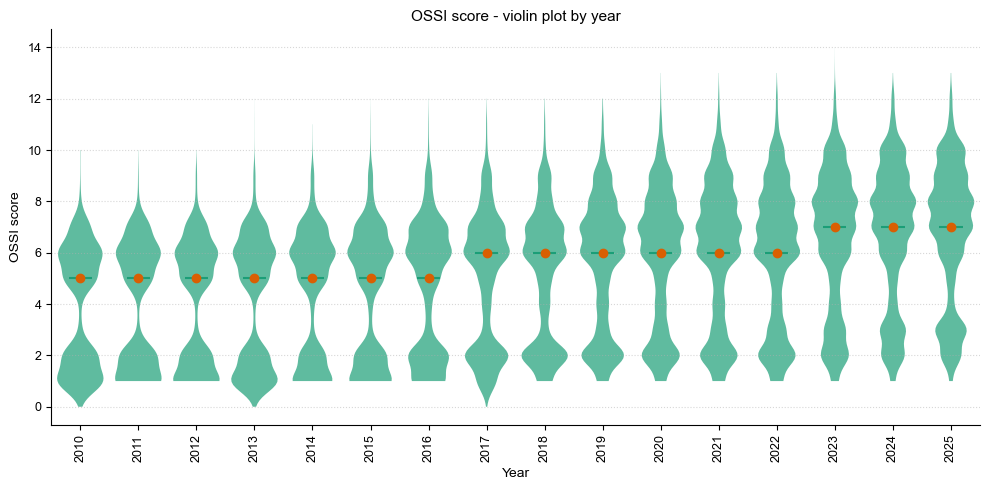

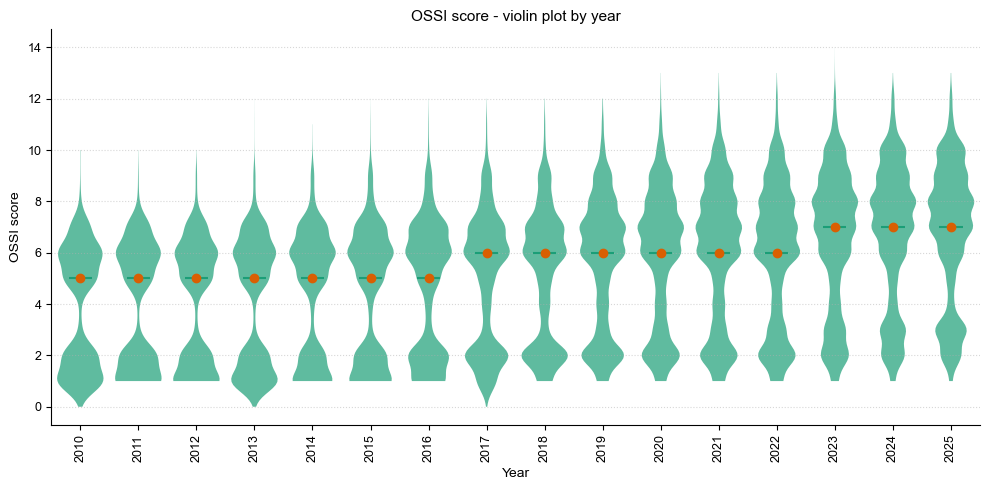

In [70]:
# Long format TSV for violin plot (same structure as boxplot one, kept separate)
violin_tsv = out_open / "ossi_score_violin_by_year.tsv"
df[[year_col, "ossi_score"]].rename(columns={year_col: "year"}).to_csv(violin_tsv, sep="\t", index=False)
print(f"Wrote {violin_tsv}")

d = df[[year_col, "ossi_score"]].dropna().copy()
d[year_col] = pd.to_numeric(d[year_col], errors="coerce")
d = d.dropna(subset=[year_col])
years_present = sorted(d[year_col].unique())
data_by_year = [d.loc[d[year_col] == y, "ossi_score"].values for y in years_present]

fig_w = max(10, 0.4 * len(years_present))
fig, ax = plt.subplots(figsize=(fig_w, 5))

positions = np.arange(1, len(years_present) + 1)

vp = ax.violinplot(
    data_by_year,
    positions=positions,
    widths=0.8,
    showmeans=False,
    showmedians=True,
    showextrema=False,
)

for body in vp["bodies"]:
    body.set_alpha(0.7)

medians = [np.median(v) if len(v) else np.nan for v in data_by_year]
ax.plot(positions, medians, marker="o", linestyle="None")

ax.set_xticks(positions)
ax.set_xticklabels([str(int(y)) for y in years_present], rotation=90, ha="center")
ax.set_xlim(0.5, len(years_present) + 0.5)

ax.set_xlabel("Year")
ax.set_ylabel("OSSI score")
ax.set_title("OSSI score - violin plot by year")
ax.grid(True, axis="y", linestyle=":", alpha=0.5)

png = out_open / "ossi_score_violin_by_year.png"
pdf = out_open / "ossi_score_violin_by_year.pdf"
fig.tight_layout()
fig.savefig(png)
fig.savefig(pdf)

fig


## 5. OSSI tiers by year - stacked 100 percent bars

OSSI tiers (Gold, Silver, Bronze, None) collapse the score into categories. We show, for each year, the percentage of papers in each tier.


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_tier_stacked_pct_by_year.tsv


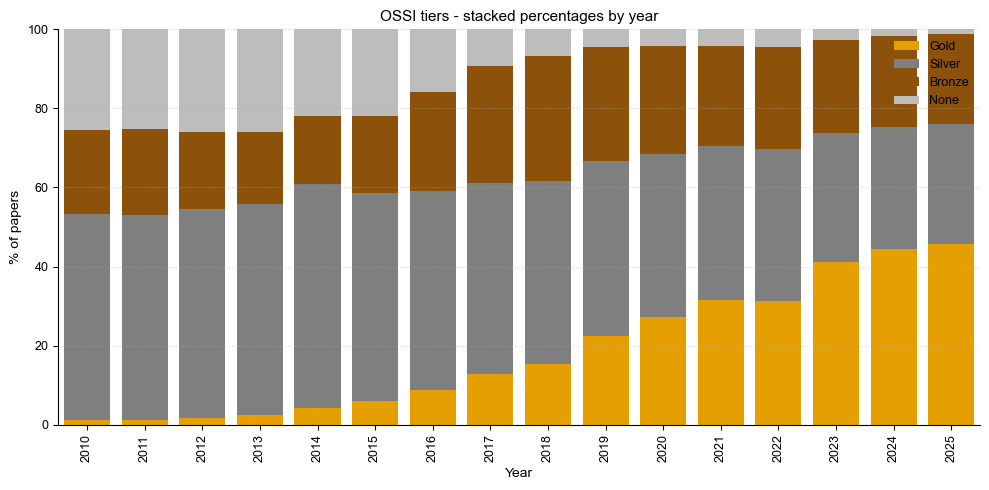

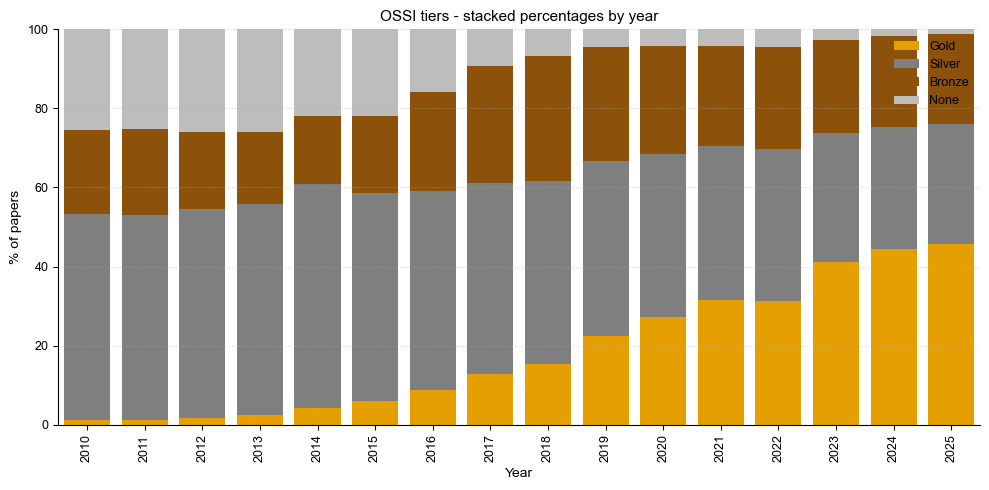

In [71]:
def tier_percent_by_year(df: pd.DataFrame, year_col: str) -> pd.DataFrame:
    d = df[[year_col, "ossi_tier"]].copy()
    d["ossi_tier"] = d["ossi_tier"].fillna("None")
    order = ["Gold", "Silver", "Bronze", "None"]
    d.loc[~d["ossi_tier"].isin(order), "ossi_tier"] = "None"

    ct = d.groupby([year_col, "ossi_tier"]).size().unstack(fill_value=0)
    for t in order:
        if t not in ct.columns:
            ct[t] = 0
    ct = ct[order]
    pct = (ct.T / ct.sum(axis=1)).T * 100.0
    pct = pct.reset_index().rename(columns={year_col: "year"}).sort_values("year")
    return pct

pct_tiers_year = tier_percent_by_year(df, year_col)

pct_tsv = out_open / "ossi_tier_stacked_pct_by_year.tsv"
pct_tiers_year.to_csv(pct_tsv, sep="\t", index=False)
print(f"Wrote {pct_tsv}")

years_present = pct_tiers_year["year"].tolist()
n = len(years_present)
positions = np.arange(1, n + 1)

tiers = ["Gold", "Silver", "Bronze", "None"]
palette_tiers = {
    "Gold": "#E69F00",
    "Silver": "#7F7F7F",
    "Bronze": "#8C510A",
    "None": "#BDBDBD",
}

vals = {}
for t in tiers:
    if t in pct_tiers_year.columns:
        vals[t] = pct_tiers_year.set_index("year").reindex(years_present)[t].fillna(0).values
    else:
        vals[t] = np.zeros(n)

fig_w = max(10, 0.4 * n)
fig, ax = plt.subplots(figsize=(fig_w, 5))

bottom = np.zeros(n)
for t in tiers:
    ax.bar(
        positions,
        vals[t],
        bottom=bottom,
        label=t,
        color=palette_tiers[t],
        edgecolor="none",
        linewidth=0.25,
    )
    bottom += vals[t]

ax.set_xticks(positions)
ax.set_xticklabels([str(int(y)) for y in years_present], rotation=90, ha="center")
ax.set_xlim(0.5, n + 0.5)
ax.set_ylim(0, 100)

ax.set_xlabel("Year")
ax.set_ylabel("% of papers")
ax.set_title("OSSI tiers - stacked percentages by year")
ax.legend(loc="upper right", frameon=False)
ax.grid(True, axis="y", linestyle=":", alpha=0.5)

png = out_open / "ossi_tier_stacked_pct_by_year.png"
pdf = out_open / "ossi_tier_stacked_pct_by_year.pdf"
fig.tight_layout()
fig.savefig(png)
fig.savefig(pdf)

fig


## 6. Open science indicators by year

We now inspect each individual indicator (data in public repositories, dataset DOIs, code availability, protocol sharing, source data files) and compute the percentage of papers that are positive for each indicator per year.


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_indicator_pct_by_year.tsv


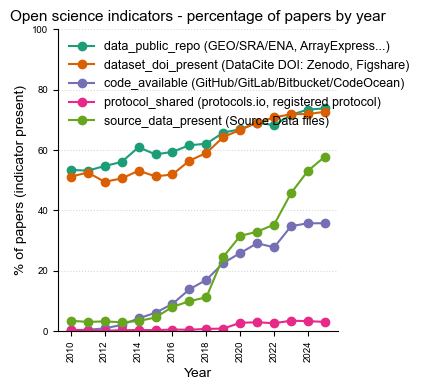

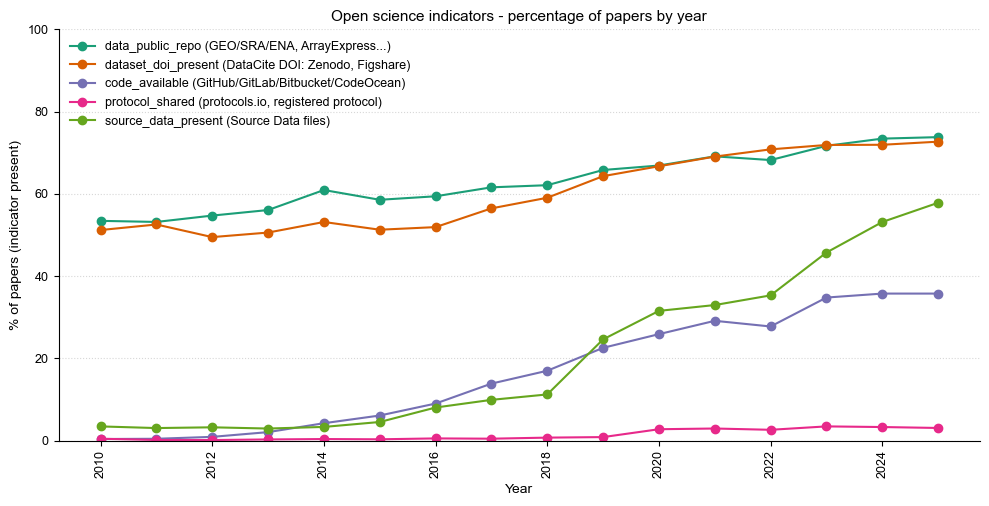

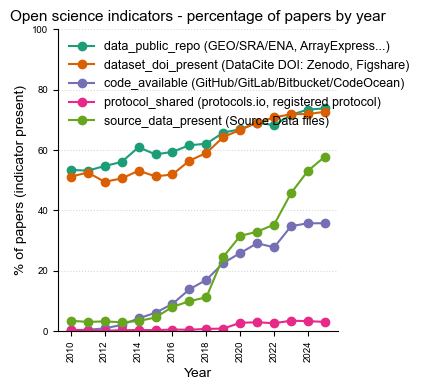

In [101]:
INDICATOR_COLS = [
    "data_public_repo",
    "dataset_doi_present",
    "code_available",
    "protocol_shared",
    "source_data_present",
]

LEGEND_LABELS = {
    "data_public_repo":   "data_public_repo (GEO/SRA/ENA, ArrayExpress...)",
    "dataset_doi_present":"dataset_doi_present (DataCite DOI: Zenodo, Figshare)",
    "code_available":     "code_available (GitHub/GitLab/Bitbucket/CodeOcean)",
    "protocol_shared":    "protocol_shared (protocols.io, registered protocol)",
    "source_data_present":"source_data_present (Source Data files)",
}

year_vals = sorted(pd.to_numeric(df[year_col], errors="coerce").dropna().astype(int).unique())
rows = []

for metric in INDICATOR_COLS:
    if metric not in df.columns:
        print(f"[warn] column not found: {metric} - skipping")
        continue
    b = to_bool_series(df[metric])
    tmp = pd.DataFrame({"year": pd.to_numeric(df[year_col], errors="coerce"), "ok": b})
    tmp = tmp.dropna(subset=["year"]).copy()
    tmp["year"] = tmp["year"].astype(int)
    grp = tmp.groupby("year")["ok"]
    pct = (grp.mean() * 100.0).reindex(year_vals, fill_value=0)
    n = grp.size().reindex(year_vals, fill_value=0)
    for y in year_vals:
        rows.append({"year": y, "metric": metric, "pct_yes": pct.loc[y], "n": int(n.loc[y])})

pct_long = pd.DataFrame(rows).sort_values(["metric", "year"])

# Save TSV
out_tsv = out_open / "ossi_indicator_pct_by_year.tsv"
pct_long.to_csv(out_tsv, sep="\t", index=False)
print(f"Wrote {out_tsv}")

# Wide table for plotting
wide = pct_long.pivot(index="year", columns="metric", values="pct_yes").reindex(year_vals)
wide = wide[LEGEND_LABELS.keys()]

fig_w = max(10, 0.5 * len(year_vals))
fig, ax = plt.subplots(figsize=(fig_w, 5))

for metric in LEGEND_LABELS.keys():
    if metric not in wide.columns:
        continue
    ax.plot(
        wide.index,
        wide[metric],
        marker="o",
        label=LEGEND_LABELS[metric],
    )

ax.set_xlabel("Year")
ax.set_ylabel("% of papers (indicator present)")
ax.set_title("Open science indicators - percentage of papers by year")
ax.set_ylim(0, 100)
ax.grid(True, axis="y", linestyle=":", alpha=0.5)
ax.legend(loc="upper left", frameon=False, ncol=1)

png = out_open / "ossi_indicator_pct_by_year.png"
pdf = out_open / "ossi_indicator_pct_by_year.pdf"
fig.tight_layout()
ax.tick_params(axis="x", rotation=90)
fig.savefig(png)
fig.savefig(pdf)

fig

# Now square fig
# Small square fig for panel layout
fig_size = 4.0  # try 4.0 or 4.5 if you want a bit more room
fig, ax = plt.subplots(figsize=(fig_size, fig_size))

for metric in LEGEND_LABELS.keys():
    if metric not in wide.columns:
        continue
    ax.plot(
        wide.index,
        wide[metric],
        marker="o",
        label=LEGEND_LABELS[metric],
    )

ax.set_xlabel("Year")
ax.set_ylabel("% of papers (indicator present)")
ax.set_title("Open science indicators - percentage of papers by year")
ax.set_ylim(0, 100)
ax.grid(True, axis="y", linestyle=":", alpha=0.5)
ax.legend(loc="upper left", frameon=False, ncol=1)

# make x labels readable in a small panel
ax.tick_params(axis="x", rotation=90, labelsize=7)
ax.tick_params(axis="y", labelsize=7)

png = out_open / "ossi_indicator_pct_by_year_square.png"
pdf = out_open / "ossi_indicator_pct_by_year_square.pdf"
ax.tick_params(axis="x", rotation=90)
fig.tight_layout()
fig.savefig(png)
fig.savefig(pdf)

fig



## 7. Open science indicators by journal

Here we compute, for each journal, the percentage of papers that are positive for each indicator. Journals are sorted by overall open science support.


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_indicator_pct_by_journal.tsv


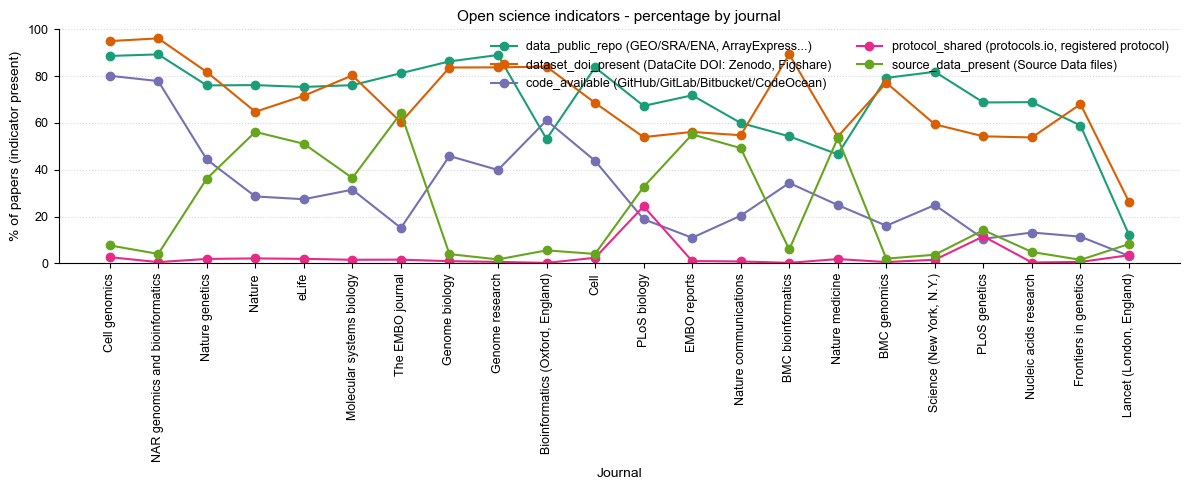

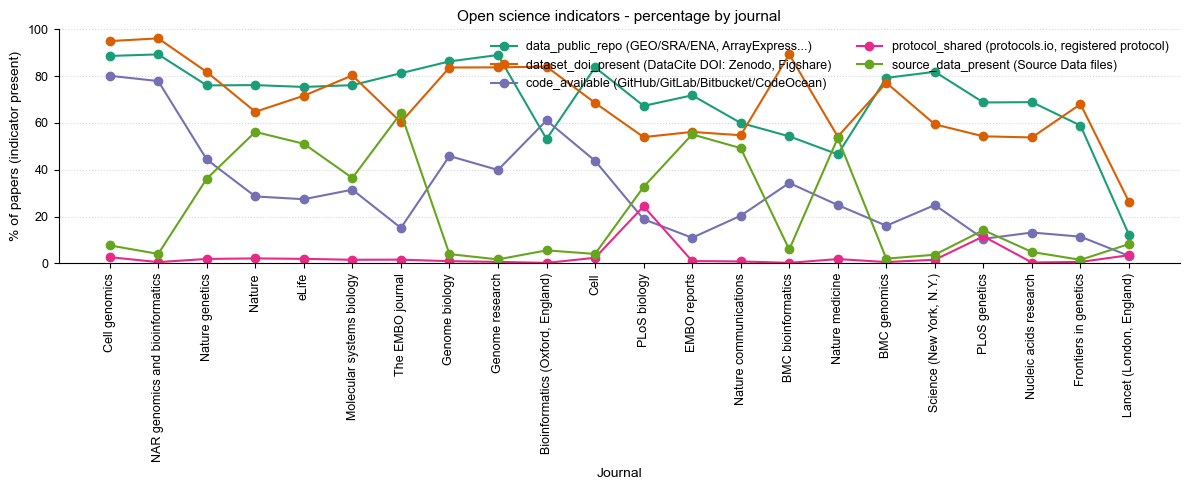

In [73]:
# Reuse LEGEND_LABELS and INDICATOR_COLS from previous cell

JOURNAL_COL = journal_col

journals = sorted(df[JOURNAL_COL].astype(str).unique())
rows = []
for metric in INDICATOR_COLS:
    if metric not in df.columns:
        print(f"[warn] column not found: {metric} - skipping")
        continue
    b = to_bool_series(df[metric])
    tmp = pd.DataFrame({"journal": df[JOURNAL_COL].astype(str), "ok": b})
    grp = tmp.groupby("journal")["ok"]
    pct = (grp.mean() * 100.0).reindex(journals, fill_value=0)
    n = grp.size().reindex(journals, fill_value=0)
    for j in journals:
        rows.append({"journal": j, "metric": metric, "pct_yes": pct.loc[j], "n": int(n.loc[j])})

pct_long_j = pd.DataFrame(rows)

out_tsv_j = out_open / "ossi_indicator_pct_by_journal.tsv"
pct_long_j.to_csv(out_tsv_j, sep="\t", index=False)
print(f"Wrote {out_tsv_j}")

# Wide table and journal ordering by mean support
wide_j = pct_long_j.pivot(index="journal", columns="metric", values="pct_yes")
for m in INDICATOR_COLS:
    if m not in wide_j.columns:
        wide_j[m] = 0.0

wide_j["mean_support"] = wide_j[INDICATOR_COLS].mean(axis=1)
wide_j = wide_j.sort_values("mean_support", ascending=False)
journals_sorted = wide_j.index.tolist()

fig_w = max(12, 0.4 * len(journals_sorted))
fig, ax = plt.subplots(figsize=(fig_w, 5))

positions = np.arange(1, len(journals_sorted) + 1)

for metric in INDICATOR_COLS:
    if metric not in wide_j.columns:
        continue
    ax.plot(
        positions,
        wide_j.loc[journals_sorted, metric],
        marker="o",
        label=LEGEND_LABELS[metric],
    )

ax.set_xticks(positions)
ax.set_xticklabels(journals_sorted, rotation=90, ha="center")
ax.set_xlabel("Journal")
ax.set_ylabel("% of papers (indicator present)")
ax.set_title("Open science indicators - percentage by journal")
ax.set_ylim(0, 100)
ax.grid(True, axis="y", linestyle=":", alpha=0.5)
ax.legend(loc="upper right", frameon=False, ncol=2)

png = out_open / "ossi_indicator_pct_by_journal.png"
pdf = out_open / "ossi_indicator_pct_by_journal.pdf"
fig.tight_layout()
fig.savefig(png)
fig.savefig(pdf)

fig


## 11. Open science indicators by journal (grouped bar plot)

As an alternative to line plots, we also display open science indicators by journal as grouped bars. For each journal, we draw one thin bar per indicator (data repositories, dataset DOIs, code availability, protocol sharing, source data files), with height equal to the percentage of papers in that journal that are positive for the indicator.


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_indicator_pct_by_journal.tsv


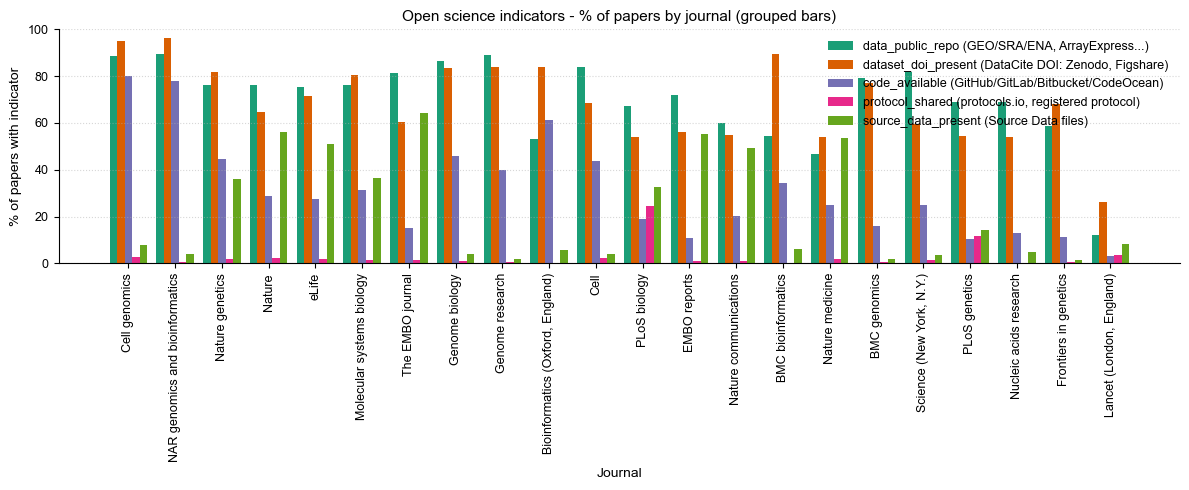

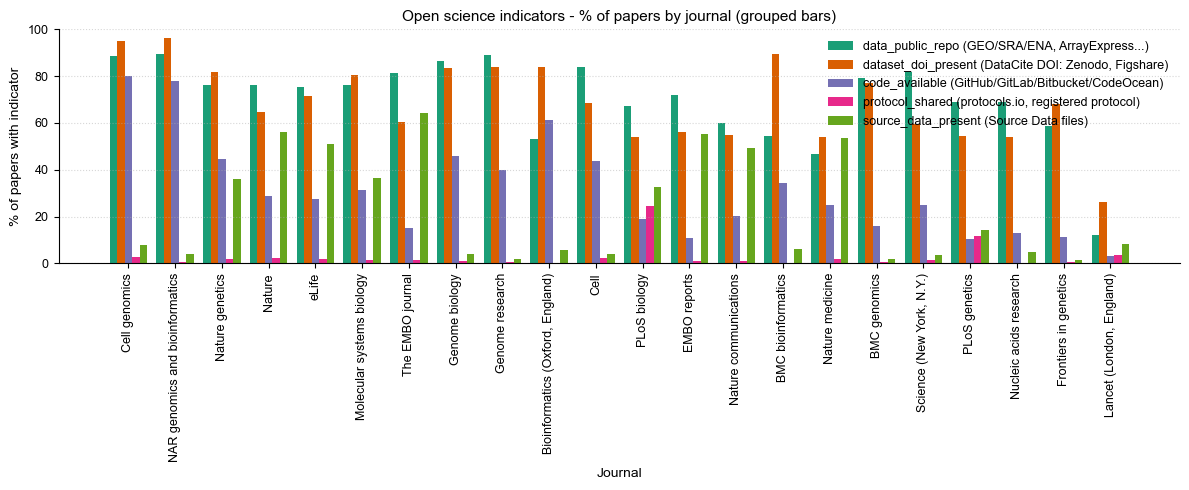

In [74]:
# Reuse INDICATOR_COLS and LEGEND_LABELS defined earlier

# Build the same wide table as in the previous indicator-by-journal section
rows = []
journals_all = sorted(df[journal_col].astype(str).unique())

for metric in INDICATOR_COLS:
    if metric not in df.columns:
        print(f"[warn] missing indicator column {metric}, skipping")
        continue
    b = to_bool_series(df[metric])
    tmp = pd.DataFrame(
        {
            "journal": df[journal_col].astype(str),
            "ok": b,
        }
    )
    grp = tmp.groupby("journal")["ok"]
    pct = (grp.mean() * 100.0).reindex(journals_all, fill_value=0)
    for j in journals_all:
        rows.append({"journal": j, "metric": metric, "pct_yes": pct.loc[j]})

pct_long_j_bars = pd.DataFrame(rows)

# Save or overwrite the generic indicator-by-journal TSV
tsv_ind_j = out_open / "ossi_indicator_pct_by_journal.tsv"
pct_long_j_bars.to_csv(tsv_ind_j, sep="\t", index=False)
print(f"Wrote {tsv_ind_j}")

# Wide table and ordering of journals by mean support
wide_j = pct_long_j_bars.pivot(index="journal", columns="metric", values="pct_yes")

for m in INDICATOR_COLS:
    if m not in wide_j.columns:
        wide_j[m] = 0.0

wide_j["mean_support"] = wide_j[INDICATOR_COLS].mean(axis=1)
wide_j = wide_j.sort_values("mean_support", ascending=False)

journals_sorted = wide_j.index.tolist()
n_j = len(journals_sorted)
x = np.arange(n_j)

n_metrics = len(INDICATOR_COLS)
bar_width = 0.8 / max(1, n_metrics)

fig_w = max(12, 0.4 * n_j)
fig, ax = plt.subplots(figsize=(fig_w, 5))

for i, metric in enumerate(INDICATOR_COLS):
    offset = (i - (n_metrics - 1) / 2) * bar_width
    vals = wide_j.loc[journals_sorted, metric].values
    label = LEGEND_LABELS.get(metric, metric)
    ax.bar(
        x + offset,
        vals,
        width=bar_width,
        label=label,
    )

ax.set_xticks(x)
ax.set_xticklabels(journals_sorted, rotation=90, ha="center")
ax.set_xlabel("Journal")
ax.set_ylabel("% of papers with indicator")
ax.set_title("Open science indicators - % of papers by journal (grouped bars)")
ax.set_ylim(0, 100)
ax.grid(True, axis="y", linestyle=":", alpha=0.5)
ax.legend(loc="upper right", frameon=False)

png = out_open / "ossi_indicator_pct_by_journal_bars.png"
pdf = out_open / "ossi_indicator_pct_by_journal_bars.pdf"
fig.tight_layout()
fig.savefig(png)
fig.savefig(pdf)

fig


## 8. OSSI tiers by journal

Finally, we show the distribution of OSSI tiers per journal as stacked 100 percent bars, ordered from highest to lowest open science support.


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_tier_stacked_pct_by_journal.tsv
Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_tier_counts_by_journal.tsv


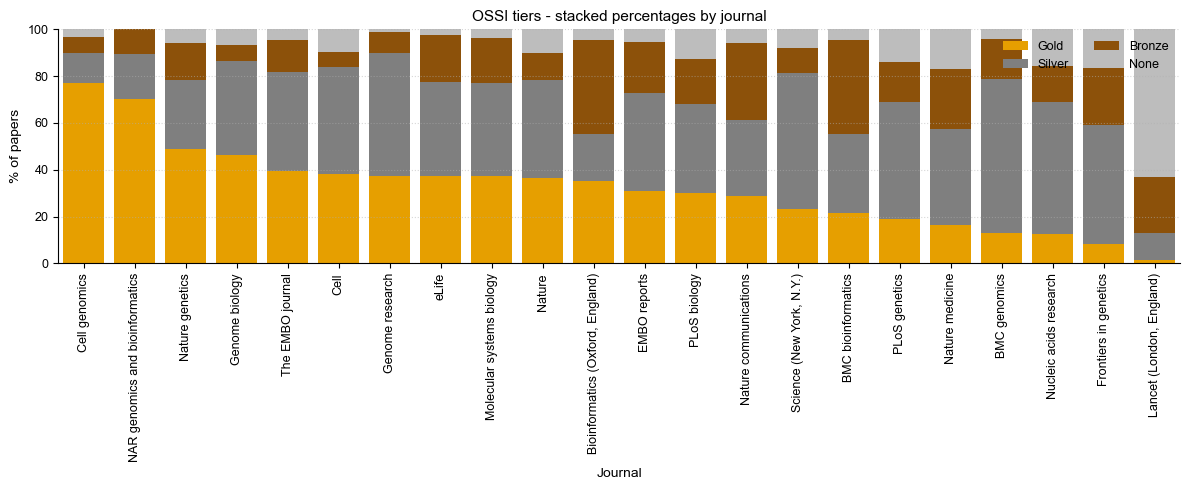

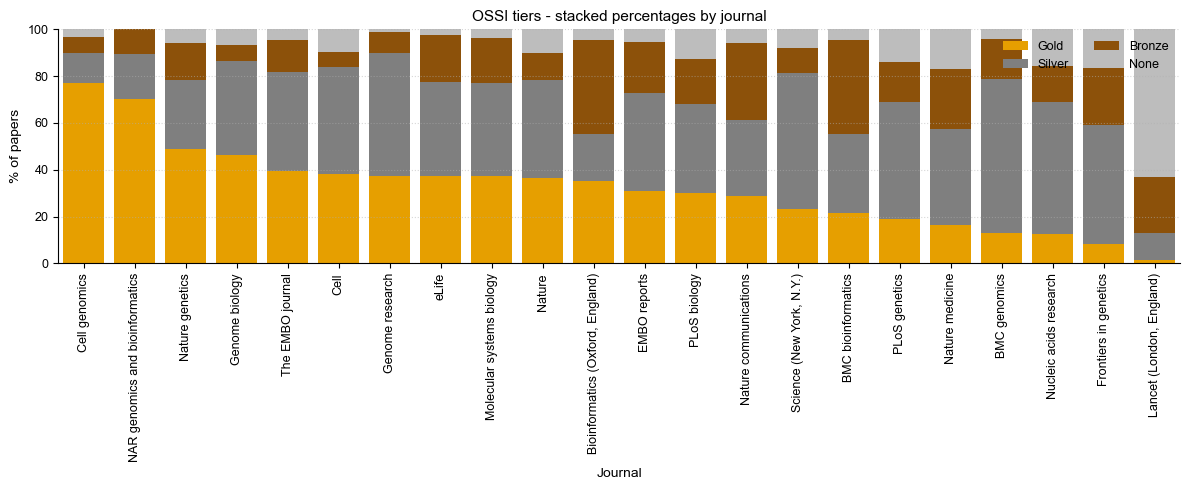

In [75]:
def tier_percent_by_group(df: pd.DataFrame, group_col: str):
    d = df[[group_col, "ossi_tier"]].copy()
    d["ossi_tier"] = d["ossi_tier"].fillna("None")
    order = ["Gold", "Silver", "Bronze", "None"]
    d.loc[~d["ossi_tier"].isin(order), "ossi_tier"] = "None"

    ct = d.groupby([group_col, "ossi_tier"]).size().unstack(fill_value=0)
    for t in order:
        if t not in ct.columns:
            ct[t] = 0
    ct = ct[order]

    pct = (ct.T / ct.sum(axis=1)).T * 100.0
    sort_cols = ["Gold", "Silver", "Bronze", "None"]
    pct = pct.sort_values(by=sort_cols, ascending=[False, False, False, True])

    pct = pct.reset_index().rename(columns={group_col: "journal"})
    ct = ct.reset_index().rename(columns={group_col: "journal"})
    return pct, ct

pctJ, ctJ = tier_percent_by_group(df, journal_col)

pct_tsv_J = out_open / "ossi_tier_stacked_pct_by_journal.tsv"
pctJ.to_csv(pct_tsv_J, sep="\t", index=False)
print(f"Wrote {pct_tsv_J}")

ct_tsv_J = out_open / "ossi_tier_counts_by_journal.tsv"
ctJ.to_csv(ct_tsv_J, sep="\t", index=False)
print(f"Wrote {ct_tsv_J}")

journals = pctJ["journal"].astype(str).tolist()
n = len(journals)
positions = np.arange(1, n + 1)

tiers = ["Gold", "Silver", "Bronze", "None"]
palette_tiers = {
    "Gold": "#E69F00",
    "Silver": "#7F7F7F",
    "Bronze": "#8C510A",
    "None": "#BDBDBD",
}

vals = {}
for t in tiers:
    if t in pctJ.columns:
        vals[t] = pctJ.set_index("journal").reindex(journals)[t].fillna(0).values
    else:
        vals[t] = np.zeros(n)

fig_w = max(12, 0.4 * n)
fig, ax = plt.subplots(figsize=(fig_w, 5))

bottom = np.zeros(n)
for t in tiers:
    ax.bar(
        positions,
        vals[t],
        bottom=bottom,
        label=t,
        color=palette_tiers[t],
        edgecolor="none",
    )
    bottom += vals[t]

ax.set_xticks(positions)
ax.set_xticklabels(journals, rotation=90, ha="center")
ax.set_xlim(0.5, n + 0.5)
ax.set_ylim(0, 100)

ax.set_xlabel("Journal")
ax.set_ylabel("% of papers")
ax.set_title("OSSI tiers - stacked percentages by journal")
ax.legend(loc="upper right", ncol=2, frameon=False)
ax.grid(True, axis="y", linestyle=":", alpha=0.5)

png = out_open / "ossi_tier_stacked_pct_by_journal.png"
pdf = out_open / "ossi_tier_stacked_pct_by_journal.pdf"
fig.tight_layout()
fig.savefig(png)
fig.savefig(pdf)

fig


## 9. OSSI tiers by year for each journal (panel view)

To visualise how journals differ in the temporal evolution of their open science support, we compute, for every journal and year, the percentage of papers in each OSSI tier (Gold, Silver, Bronze, None). We then display one stacked 100 percent bar plot per journal, arranged in panels, with a common x axis (year) and y scale (0 to 100 percent).


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_tier_stacked_pct_by_year__per_journal_panels.tsv


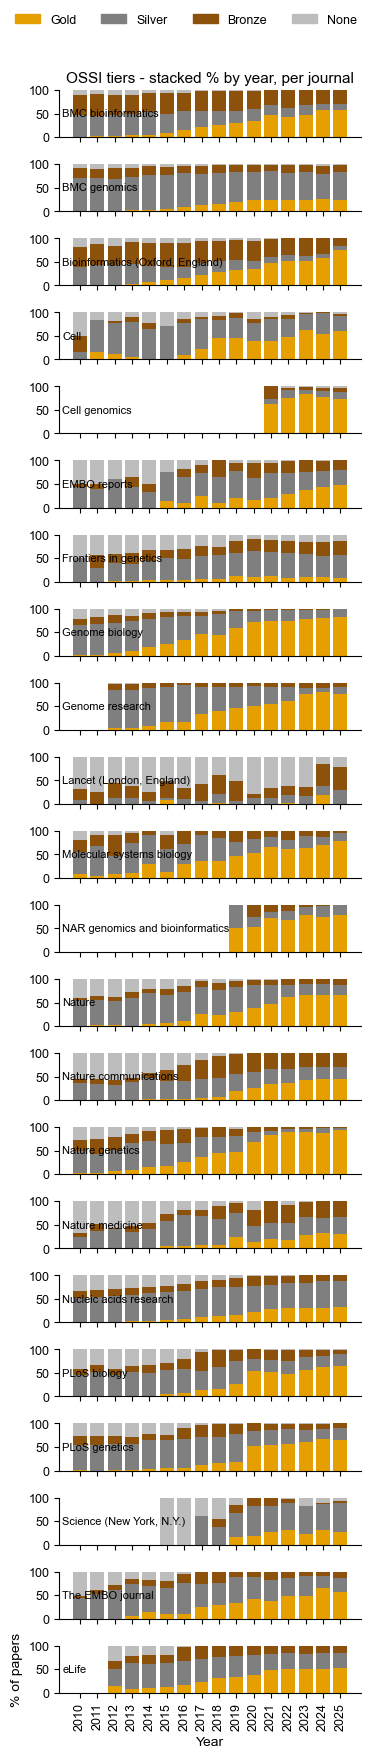

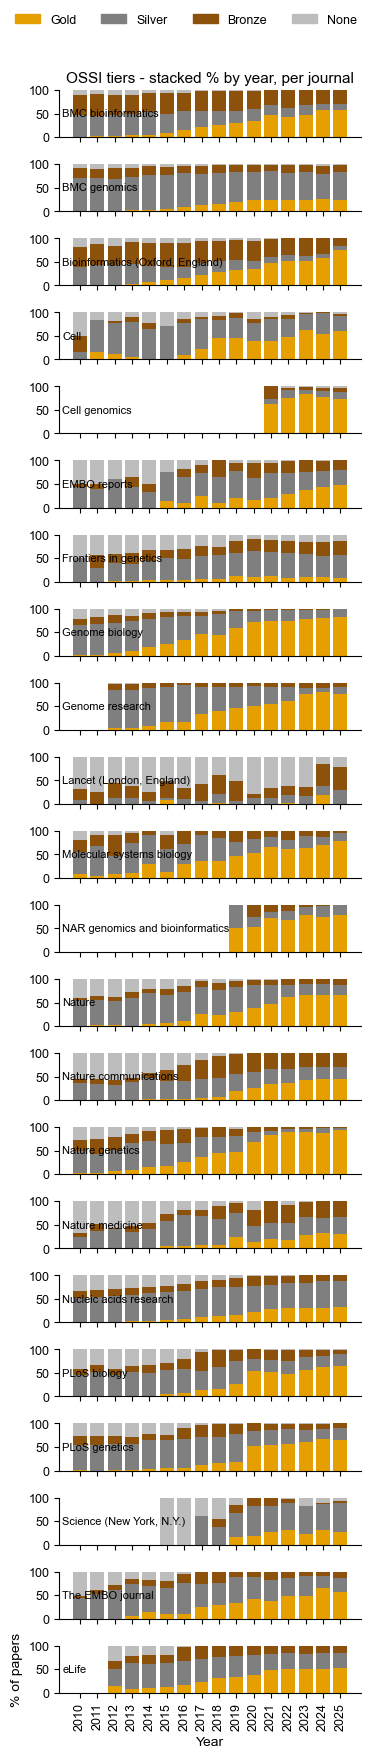

In [87]:
import numpy as np

# Define tiers and a consistent color palette
tiers = ["Gold", "Silver", "Bronze", "None"]
palette_tiers = {
    "Gold":   "#E69F00",
    "Silver": "#7F7F7F",
    "Bronze": "#8C510A",
    "None":   "#BDBDBD",
}

# Years to display
years = list(range(YEAR_MIN, YEAR_MAX + 1))

# Compute percent composition of tiers per (journal, year)
rows = []
for journal in sorted(df[journal_col].astype(str).unique()):
    for y in years:
        sub = df[(df[journal_col] == journal) & (df[year_col] == y)]
        if sub.empty:
            counts = {t: 0 for t in tiers}
        else:
            vc = sub["ossi_tier"].fillna("None")
            counts = {t: int((vc == t).sum()) for t in tiers}
        total = sum(counts.values())
        row = {"journal": journal, "year": y}
        for t in tiers:
            row[t] = 100.0 * counts[t] / total if total > 0 else 0.0
        rows.append(row)

tier_jy = pd.DataFrame(rows)

# Save TSV for reproducibility
tsv_jy = out_open / "ossi_tier_stacked_pct_by_year__per_journal_panels.tsv"
tier_jy.to_csv(tsv_jy, sep="\t", index=False)
print(f"Wrote {tsv_jy}")

# Prepare panel figure
journals_sorted = sorted(df[journal_col].astype(str).unique())
n_j = len(journals_sorted)
x = np.arange(len(years))

fig_h = max(16, 0.8 * n_j)
fig, axes = plt.subplots(
    nrows=n_j,
    ncols=1,
    sharex=True,
    figsize=(3.8, fig_h),
)

if n_j == 1:
    axes = [axes]

for i, journal in enumerate(journals_sorted):
    ax = axes[i]
    sub = tier_jy[tier_jy["journal"] == journal].set_index("year").reindex(years)

    bottom = np.zeros(len(years))
    for t in tiers:
        vals = sub[t].fillna(0.0).values
        ax.bar(
            x,
            vals,
            bottom=bottom,
            color=palette_tiers[t],
            edgecolor="none",
            linewidth=0.25,
        )
        bottom += vals

    ax.set_ylim(0, 100)
    ax.set_yticks([0, 50, 100])
    ax.text(
        0.01,
        0.5,
        journal,
        transform=ax.transAxes,
        ha="left",
        va="center",
        fontsize=8,
    )
    if i < n_j - 1:
        ax.set_xticks([])
    else:
        ax.set_xticks(x)
        ax.set_xticklabels(years, rotation=90)
        ax.set_xlabel("Year")
        ax.set_ylabel("% of papers")

axes[0].set_title("OSSI tiers - stacked % by year, per journal")

# Global legend for tiers
handles = [
    plt.Rectangle((0, 0), 1, 1, color=palette_tiers[t], label=t)
    for t in tiers
]
fig.legend(
    handles,
    [h.get_label() for h in handles],
    loc="upper center",
    ncol=len(tiers),
    frameon=False,
    bbox_to_anchor=(0.5, 1.0),
)

fig.tight_layout(rect=[0, 0, 1, 0.97])

png = out_open / "ossi_tier_stacked_pct_by_year__per_journal_panels.png"
pdf = out_open / "ossi_tier_stacked_pct_by_year__per_journal_panels.pdf"
fig.savefig(png)
fig.savefig(pdf)

fig


## 10. OSSI tiers by year, stratified by “under request” status

To compare open science practices between papers with and without “data available upon request” statements, we split the corpus into two groups:

- **not_UR**: under_request == 0  
- **UR & genuine = 0**: under_request == 1 and genuine == 0

For each year and group, we compute the percentage of papers in each OSSI tier and display paired stacked bars (left bar = not_UR, right bar = UR & genuine = 0) for each year.


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_tier_stacked_pct_by_year_notUR_vs_URg0.tsv


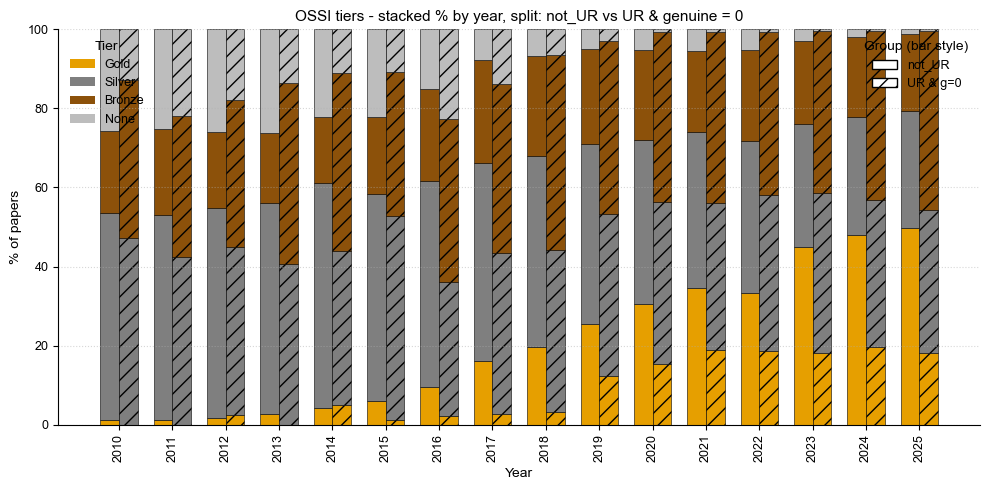

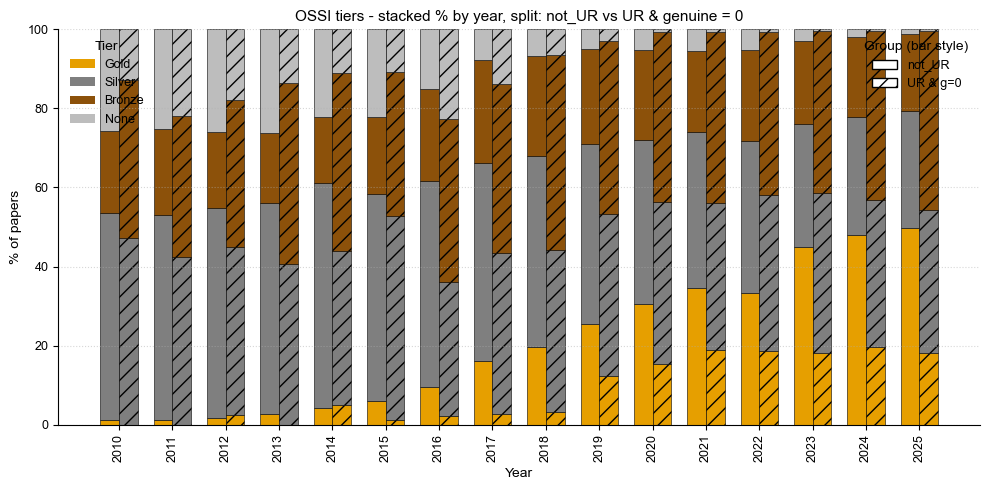

In [77]:
from matplotlib.patches import Patch

# Make sure numeric versions of UR and genuine flags exist
if "under_request_num" not in df.columns:
    df["under_request_num"] = (
        pd.to_numeric(df.get("under_request", 0), errors="coerce")
        .fillna(0)
        .astype(int)
    )

if "genuine_num" not in df.columns:
    df["genuine_num"] = (
        pd.to_numeric(df.get("genuine", 0), errors="coerce")
        .fillna(0)
        .astype(int)
    )

tiers = ["Gold", "Silver", "Bronze", "None"]
palette_tiers = {
    "Gold":   "#E69F00",
    "Silver": "#7F7F7F",
    "Bronze": "#8C510A",
    "None":   "#BDBDBD",
}

groups = ["not_UR", "UR & g=0"]

# Assign group labels with pandas, avoid dtype promotion issues
df_group = df.copy()
df_group["group"] = pd.Series(pd.NA, index=df_group.index, dtype="object")

df_group.loc[df_group["under_request_num"] == 0, "group"] = "not_UR"
df_group.loc[
    (df_group["under_request_num"] == 1) & (df_group["genuine_num"] == 0),
    "group",
] = "UR & g=0"

# Keep only rows that fall into one of the two groups
df_group = df_group[df_group["group"].notna()].copy()

years = list(range(YEAR_MIN, YEAR_MAX + 1))

rows = []
for y in years:
    for g in groups:
        sub = df_group[(df_group[year_col] == y) & (df_group["group"] == g)]
        if sub.empty:
            counts = {t: 0 for t in tiers}
        else:
            vc = sub["ossi_tier"].fillna("None")
            counts = {t: int((vc == t).sum()) for t in tiers}
        total = sum(counts.values())
        row = {"year": y, "group": g}
        for t in tiers:
            row[t] = 100.0 * counts[t] / total if total > 0 else 0.0
        rows.append(row)

tier_yg = pd.DataFrame(rows)

tsv_yg = out_open / "ossi_tier_stacked_pct_by_year_notUR_vs_URg0.tsv"
tier_yg.to_csv(tsv_yg, sep="\t", index=False)
print(f"Wrote {tsv_yg}")

# Plot: two bars per year (left not_UR, right UR & g=0)
x = np.arange(len(years))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))

for i, g in enumerate(groups):
    x_pos = x - width / 2 if g == "not_UR" else x + width / 2
    sub = tier_yg[tier_yg["group"] == g].set_index("year").reindex(years)
    bottom = np.zeros(len(years))
    hatch = "" if g == "not_UR" else "//"
    for t in tiers:
        vals = sub[t].fillna(0.0).values
        ax.bar(
            x_pos,
            vals,
            width=width,
            bottom=bottom,
            color=palette_tiers[t],
            edgecolor="black",
            linewidth=0.4,
            hatch=hatch,
        )
        bottom += vals

ax.set_xticks(x)
ax.set_xticklabels(years, rotation=90)
ax.set_ylim(0, 100)
ax.set_xlabel("Year")
ax.set_ylabel("% of papers")
ax.set_title("OSSI tiers - stacked % by year, split: not_UR vs UR & genuine = 0")

# Legend 1: tiers (color)
tier_handles = [Patch(facecolor=palette_tiers[t], label=t) for t in tiers]
legend1 = ax.legend(
    handles=tier_handles,
    title="Tier",
    loc="upper left",
    frameon=False,
)

# Legend 2: groups (bar style)
group_handles = [
    Patch(facecolor="white", edgecolor="black", hatch="", label="not_UR"),
    Patch(facecolor="white", edgecolor="black", hatch="//", label="UR & g=0"),
]
legend2 = ax.legend(
    handles=group_handles,
    title="Group (bar style)",
    loc="upper right",
    frameon=False,
)
ax.add_artist(legend1)

ax.grid(True, axis="y", linestyle=":", alpha=0.5)

png = out_open / "ossi_tier_stacked_pct_by_year_notUR_vs_URg0.png"
pdf = out_open / "ossi_tier_stacked_pct_by_year_notUR_vs_URg0.pdf"
fig.tight_layout()
fig.savefig(png)
fig.savefig(pdf)

fig


### 10b. OSSI tiers by year in two panels (not_UR vs UR & genuine = 0)

For a clearer comparison within each group, we also plot OSSI tier distributions in two aligned panels: the left panel shows not_UR papers only, and the right panel shows UR & genuine = 0 papers only.


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_tier_stacked_pct_by_year_notUR_vs_URg0_panels_row.tsv


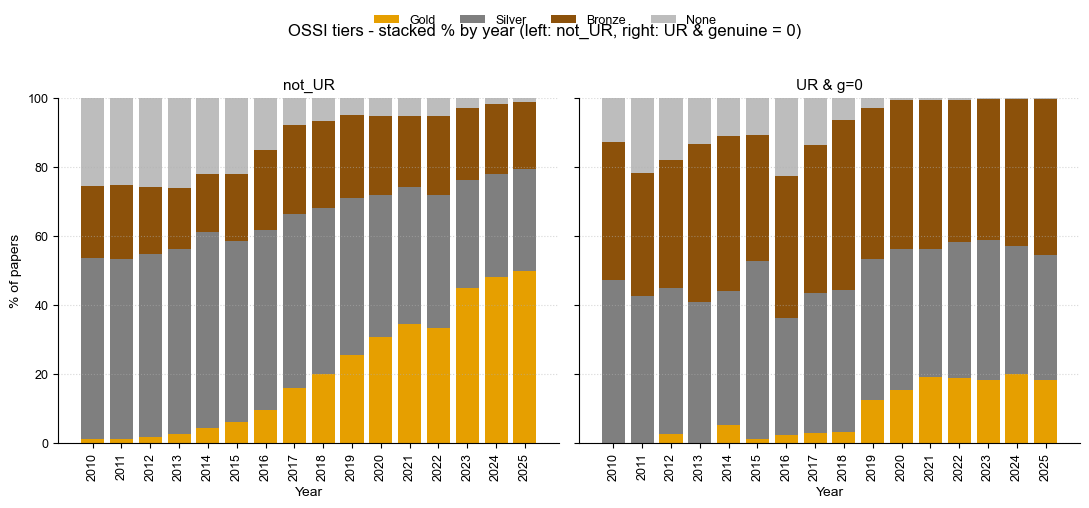

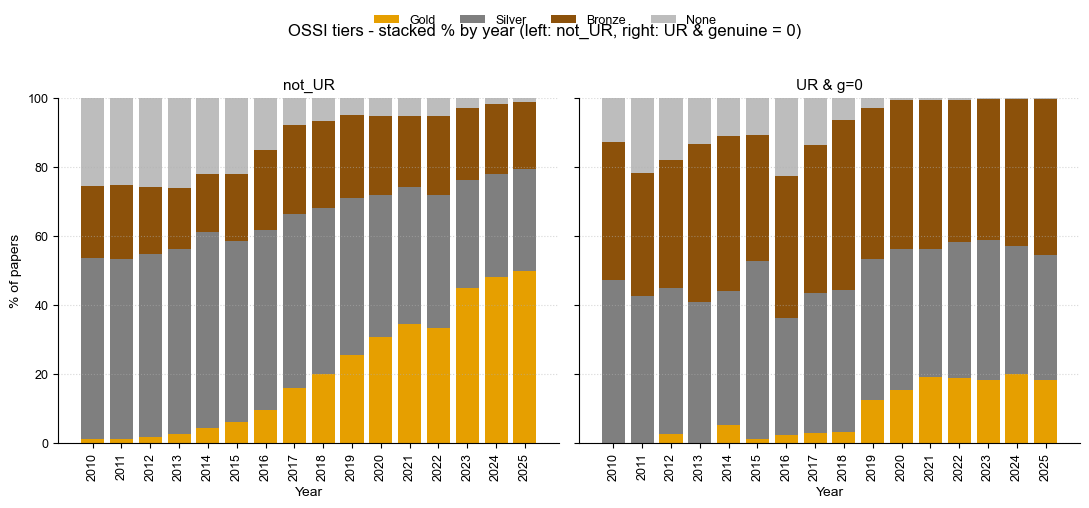

In [78]:
from matplotlib.patches import Patch
import numpy as np

# If tier_yg is not in memory (eg after a fresh kernel), try to reload it from TSV
if "tier_yg" not in globals():
    tsv_yg = out_open / "ossi_tier_stacked_pct_by_year_notUR_vs_URg0.tsv"
    if not tsv_yg.exists():
        raise FileNotFoundError(
            f"{tsv_yg} not found. "
            "Run the previous cell (section 10) to compute tier_yg and write this TSV."
        )
    tier_yg = pd.read_csv(tsv_yg, sep="\t")
    print(f"Reloaded tier_yg from {tsv_yg}")

# We also need tiers, palette_tiers, groups, years
tiers = ["Gold", "Silver", "Bronze", "None"]
palette_tiers = {
    "Gold":   "#E69F00",
    "Silver": "#7F7F7F",
    "Bronze": "#8C510A",
    "None":   "#BDBDBD",
}
groups = ["not_UR", "UR & g=0"]
years = list(range(YEAR_MIN, YEAR_MAX + 1))

fig, axes = plt.subplots(1, 2, figsize=(11, 5), sharey=True)

for j, g in enumerate(groups):
    ax = axes[j]
    sub = tier_yg[tier_yg["group"] == g].set_index("year").reindex(years)
    x = np.arange(len(years))
    bottom = np.zeros(len(years))
    for t in tiers:
        vals = sub[t].fillna(0.0).values
        ax.bar(
            x,
            vals,
            bottom=bottom,
            color=palette_tiers[t],
            edgecolor="none",
        )
        bottom += vals
    ax.set_xticks(x)
    ax.set_xticklabels(years, rotation=90)
    ax.set_ylim(0, 100)
    ax.set_xlabel("Year")
    if j == 0:
        ax.set_ylabel("% of papers")
    ax.set_title(g)
    ax.grid(True, axis="y", linestyle=":", alpha=0.5)

fig.suptitle("OSSI tiers - stacked % by year (left: not_UR, right: UR & genuine = 0)")

handles = [Patch(facecolor=palette_tiers[t], label=t) for t in tiers]
fig.legend(
    handles,
    [h.get_label() for h in handles],
    loc="upper center",
    ncol=len(tiers),
    frameon=False,
    bbox_to_anchor=(0.5, 1.02),
)

fig.tight_layout(rect=[0, 0, 1, 0.96])

png = out_open / "ossi_tier_stacked_pct_by_year_notUR_vs_URg0_panels_row.png"
pdf = out_open / "ossi_tier_stacked_pct_by_year_notUR_vs_URg0_panels_row.pdf"

fig.savefig(png)
fig.savefig(pdf)

# Optionally write TSV (same as previous cell, but with a clearer name)
tsv_panels = out_open / "ossi_tier_stacked_pct_by_year_notUR_vs_URg0_panels_row.tsv"
tier_yg.to_csv(tsv_panels, sep="\t", index=False)
print(f"Wrote {tsv_panels}")

fig


### 13. Side-by-side view of UR usage and OSSI tiers by journal

To compare open-science performance across journals, we place two horizontal stacked barplots side by side:

- on the left, the share of `ok_analysis == 1` papers that are **not_UR**, **UR & genuine==0**, or **UR & genuine==1**;
- on the right, for the same set of papers and journals, the distribution of **OSSI tiers** (Gold, Silver, Bronze, None).

Both panels use the same journal order (sorted by total UR share) and the same 0–100 % scale, which allows a direct visual comparison between how often “under request” wording occurs and how strongly each journal supports open-science practices overall.


Papers with ok_analysis == 1 in window 2010-2025: 123211
Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_vs_under_request_by_journal/ossi_vs_under_request_pct_by_journal.tsv


/var/folders/pr/t5bb5byn5tncy6zzlvx48khr0000gn/T/ipykernel_5734/2757617158.py:262: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


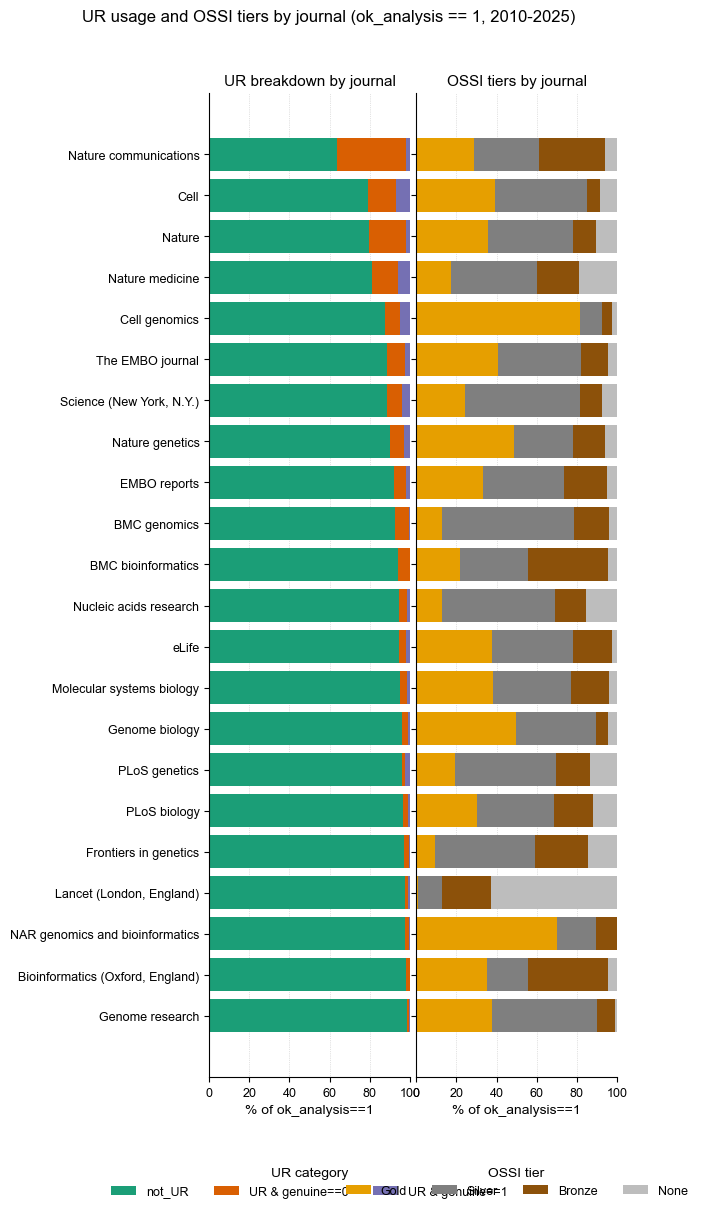

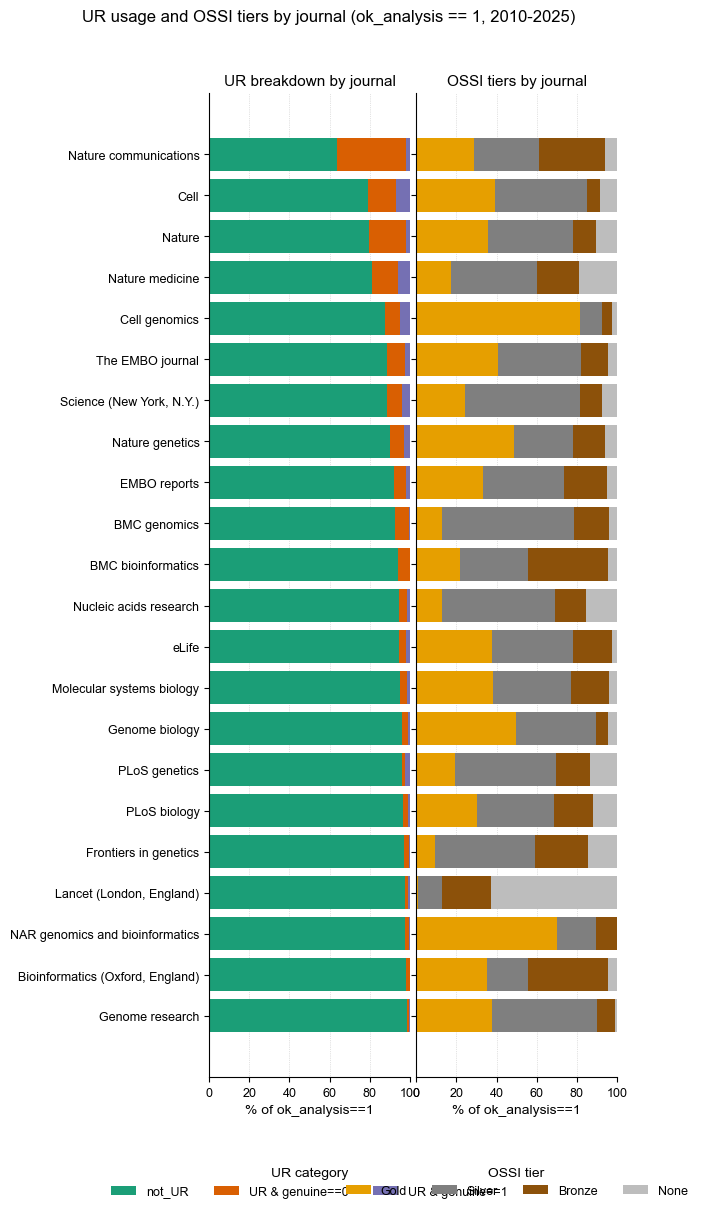

In [130]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import display

# -----------------------------------------------------------
# Combined per-journal UR breakdown and OSSI tiers (ok_analysis==1)
# -----------------------------------------------------------

df_j = df.copy()

# Numeric flags
df_j["ok_analysis_num"] = (
    pd.to_numeric(df_j.get("ok_analysis", 0), errors="coerce").fillna(0).astype(int)
)
df_j["under_request_num"] = (
    pd.to_numeric(df_j.get("under_request", 0), errors="coerce").fillna(0).astype(int)
)
df_j["genuine_num"] = (
    pd.to_numeric(df_j.get("genuine", 0), errors="coerce").fillna(0).astype(int)
)

# Journal column
if "journal" in df_j.columns:
    JCOL = "journal"
elif "journal_title" in df_j.columns:
    JCOL = "journal_title"
else:
    raise ValueError("No journal column found in df")

# Year column
if "year" in df_j.columns:
    YCOL = "year"
elif "pub_year" in df_j.columns:
    YCOL = "pub_year"
else:
    YCOL = None

mask_ok = df_j["ok_analysis_num"] == 1
if YCOL is not None:
    df_j[YCOL] = pd.to_numeric(df_j[YCOL], errors="coerce")
    mask_year = df_j[YCOL].between(YEAR_MIN, YEAR_MAX)
    df_j = df_j[mask_ok & mask_year].copy()
else:
    df_j = df_j[mask_ok].copy()

df_j = df_j.dropna(subset=[JCOL])
print(f"Papers with ok_analysis == 1 in window {YEAR_MIN}-{YEAR_MAX}: {len(df_j)}")

# Normalise ossi_tier
df_j["ossi_tier"] = (
    df_j["ossi_tier"]
    .replace("", np.nan)
    .fillna("None")
)

OSSI_TIERS = ["Gold", "Silver", "Bronze", "None"]

# -----------------------
# UR breakdown by journal
# -----------------------
rows_ur = []
for journal, sub in df_j.groupby(JCOL):
    total_j = len(sub)
    if total_j == 0:
        continue

    n_not_ur = (sub["under_request_num"] == 0).sum()
    n_ur_g1 = ((sub["under_request_num"] == 1) & (sub["genuine_num"] == 1)).sum()
    n_ur_g0 = ((sub["under_request_num"] == 1) & (sub["genuine_num"] == 0)).sum()

    rows_ur.append(
        {
            "journal": journal,
            "n_total": total_j,
            "n_not_UR": n_not_ur,
            "n_UR_g1": n_ur_g1,
            "n_UR_g0": n_ur_g0,
        }
    )

ur_j = pd.DataFrame(rows_ur)

# Percentages
for col in ["n_not_UR", "n_UR_g1", "n_UR_g0"]:
    ur_j[f"pct_{col}"] = ur_j[col] / ur_j["n_total"] * 100.0

# Sort so that smallest not_UR ends up at the TOP of the plot:
# with barh, the LAST row is at the top, so we sort DESC by not_UR.
ur_j = ur_j.sort_values("pct_n_not_UR", ascending=False)
journal_order = ur_j["journal"].tolist()

# -----------------------
# OSSI tiers by journal
# -----------------------
rows_ossi = []
for journal, sub in df_j.groupby(JCOL):
    total_j = len(sub)
    if total_j == 0:
        continue

    counts = sub["ossi_tier"].value_counts().reindex(OSSI_TIERS, fill_value=0)
    for tier in OSSI_TIERS:
        n = int(counts[tier])
        pct = 100.0 * n / total_j if total_j > 0 else 0.0
        rows_ossi.append(
            {
                "journal": journal,
                "ossi_tier": tier,
                "n": n,
                "pct": pct,
                "n_total": total_j,
            }
        )

ossi_j = pd.DataFrame(rows_ossi)

# Pivot to wide form
ur_pct_wide = ur_j.set_index("journal")[
    ["pct_n_not_UR", "pct_n_UR_g0", "pct_n_UR_g1"]
].rename(
    columns={
        "pct_n_not_UR": "not_UR",
        "pct_n_UR_g0": "UR & genuine==0",
        "pct_n_UR_g1": "UR & genuine==1",
    }
)

ossi_pct_wide = (
    ossi_j.pivot(index="journal", columns="ossi_tier", values="pct")
    .reindex(columns=OSSI_TIERS)
    .fillna(0.0)
)

# Same journal order
ur_pct_wide = ur_pct_wide.reindex(journal_order)
ossi_pct_wide = ossi_pct_wide.reindex(journal_order)

# Save TSV
out_combined = out_open / "ossi_vs_under_request_by_journal"
out_combined.mkdir(parents=True, exist_ok=True)
combined_tsv = out_combined / "ossi_vs_under_request_pct_by_journal.tsv"
pd.concat(
    [
        ur_pct_wide.add_prefix("UR_"),
        ossi_pct_wide.add_prefix("OSSI_"),
    ],
    axis=1,
).to_csv(combined_tsv, sep="\t")
print(f"Wrote {combined_tsv}")

# -----------------------
# Plot side-by-side panels
# -----------------------
n_j = len(journal_order)
y = np.arange(n_j)

try:
    color_not_ur = COLOR_NOT_UR
    color_ur_g0 = COLOR_UR_G0
    color_ur_g1 = COLOR_UR_G1
except NameError:
    color_not_ur = "#1b9e77"
    color_ur_g0 = "#d95f02"
    color_ur_g1 = "#7570b3"

tier_colors = {
    t: palette_tiers.get(t, f"C{i}") for i, t in enumerate(OSSI_TIERS)
}

# 1) Overall size: tall enough for 22 journals, not too wide
fig_w = 6                       # narrower for figure in a panel
fig_h = max(12, 0.35 * n_j)    # increase if journal names are tight
fig, axes = plt.subplots(
    1, 2, sharey=True,
    figsize=(fig_w, fig_h),
    gridspec_kw={"wspace": 0.03}, #  so box are almost-joined panels: to play around (0.01–0.05)
)


ax_ur, ax_ossi = axes

# Left: UR breakdown
ax_ur = axes[0]
bottom = np.zeros(n_j)

for label, col, col_color in [
    ("not_UR", "not_UR", color_not_ur),
    ("UR & genuine==0", "UR & genuine==0", color_ur_g0),
    ("UR & genuine==1", "UR & genuine==1", color_ur_g1),
]:
    vals = ur_pct_wide[col].values
    ax_ur.barh(
        y,
        vals,
        left=bottom,
        color=col_color,
        #edgecolor="black",
        edgecolor="none",   # no border
        linewidth=0.4,
        label=label,
    )
    bottom += vals

ax_ur.set_yticks(y)
ax_ur.set_yticklabels(journal_order)
ax_ur.set_xlabel("% of ok_analysis==1")
ax_ur.set_title("UR breakdown by journal")
ax_ur.set_xlim(0, 100)
ax_ur.xaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
ax_ur.set_axisbelow(True)

# Right: OSSI tiers
ax_ossi = axes[1]
bottom = np.zeros(n_j)

for tier in OSSI_TIERS:
    vals = ossi_pct_wide[tier].values
    ax_ossi.barh(
        y,
        vals,
        left=bottom,
        color=tier_colors[tier],
        edgecolor="none",
        linewidth=0.4,
        label=tier,
    )
    bottom += vals

ax_ossi.set_yticks(y)
ax_ossi.set_yticklabels(journal_order)
ax_ossi.set_xlabel("% of ok_analysis==1")
ax_ossi.set_title("OSSI tiers by journal")
ax_ossi.set_xlim(0, 100)
ax_ossi.xaxis.grid(True, linestyle=":", linewidth=0.5, alpha=0.7)
ax_ossi.set_axisbelow(True)

# No invert_yaxis here – sorting above ensures smallest not_UR is at top

ax_ur.legend(
    title="UR category",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.08),
    frameon=False,
    ncol=3,
)
ax_ossi.legend(
    title="OSSI tier",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.08),
    frameon=False,
    ncol=4,
)

fig.suptitle(
    f"UR usage and OSSI tiers by journal (ok_analysis == 1, {YEAR_MIN}-{YEAR_MAX})",
    y=0.99,
)

fig.tight_layout()
#fig.tight_layout(rect=[0, 0.06, 1, 0.97])
#fig.tight_layout(rect=[0.23, 0.06, 0.98, 0.96])   # [left, bottom, right, top] in figure coords
#  Manually modufy to ahve enough space on the left and top for labels + suptitle
fig.subplots_adjust(left=0.30, right=0.98, top=0.92, bottom=0.10)

png_path = out_combined / "ossi_vs_under_request_pct_by_journal.png"
pdf_path = out_combined / "ossi_vs_under_request_pct_by_journal.pdf"
fig.savefig(png_path, dpi=300)
fig.savefig(pdf_path)

fig


## Final cell - combined summary PDF

With a single multi page PDF:

In [79]:
# List of PNGs produced earlier in this notebook / scripts
# (add/remove entries here if you change file names later)
fig_files = [
    "ossi_score_hist_all.png",
    "ossi_score_median_iqr_by_year.png",
    "ossi_score_boxplot_by_year.png",
    "ossi_score_violin_by_year.png",
    "ossi_tier_stacked_pct_by_year.png",
    "ossi_indicator_pct_by_year.png",
    "ossi_indicator_pct_by_journal.png",
    "ossi_indicator_pct_by_journal_bars.png",
    "ossi_tier_stacked_pct_by_journal.png",
    "ossi_tier_stacked_pct_by_year__per_journal_panels.png",
    "ossi_tier_stacked_pct_by_year_notUR_vs_URg0.png",
    "ossi_tier_stacked_pct_by_year_notUR_vs_URg0_panels_row.png",
]

summary_pdf = out_open / "ossi_summary.pdf"

with PdfPages(summary_pdf) as pdf_out:
    for fname in fig_files:
        path = out_open / fname
        if not path.exists():
            print(f"[warn] file not found, skipping in summary: {path}")
            continue
        img = plt.imread(path)
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.imshow(img)
        ax.axis("off")
        pdf_out.savefig(fig, bbox_inches="tight")
        plt.close(fig)

print(f"Wrote {summary_pdf}")


Wrote /Users/benoit/work/under_request/4.analyses/open_science/ossi_summary.pdf
